In [2]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.distributions as D
from torch.optim import Adam, SGD, lr_scheduler
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
from IPython.display import clear_output

from torch.distributions import Normal, Independent, Categorical, MixtureSameFamily

In [3]:
np.random.seed(0)

In [4]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device


'cpu'

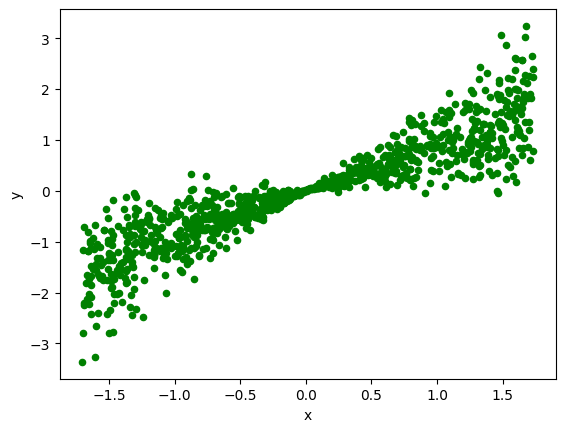

In [5]:
n = 1000
X = np.random.uniform(0, 10, size=(n, 1)).astype(np.float32)
y = (2 * X + 1 + np.random.normal(0, 1, size=(n, 1)) * (X - 5)).astype(
    np.float32
)  # Heteroscedasticity
#y = (2 * X + 1 + 3*np.random.normal(0, 1, size=(n, 1))).astype(
#    np.float32
#)  # Heteroscedasticity


X = (X - X.mean()) / X.std()
y = (y - y.mean()) / y.std()

data = pd.DataFrame({"x": X.squeeze(), "y": y.squeeze()}).plot(
    kind="scatter", x="x", y="y", color="green"
);


In [5]:
def plot_credibility_interval(model, X, y, num_samples=50, fig=None, ax=None, y_min=-20, y_max=20):
    if (fig is None) or (ax is None):
        fig, ax = plt.subplots()
    # Plot actual data
    X_np = X.detach().to(device="cpu").numpy()
    y_np = y.detach().to(device="cpu").numpy()
    scatter_actual = ax.scatter(X_np, y_np, color="green", label="Actual")

    sorting = X.detach().to(device="cpu").squeeze().sort()
    X_sorted = sorting.values.unsqueeze(1)

    predictions = []
    # Run multiple forward passes to get predictions for each input
    for _ in range(num_samples):
        y_hat_sample = model(X_sorted)[0]
        y_hat_np = y_hat_sample.to(device="cpu").detach().numpy().squeeze()
        predictions.append(y_hat_np)

    # Convert the predictions to a NumPy array for easier manipulation
    predictions = np.array(predictions)

    # Calculate mean and standard deviation across the samples
    y_hat_mean = predictions.mean(axis=0)
    y_hat_std = predictions.std(axis=0)

    # Calculate the 68.2% prediction interval (mean ± std)
    lower_bound = y_hat_mean - y_hat_std
    upper_bound = y_hat_mean + y_hat_std

    # Plot the prediction interval as a shaded region
    ax.fill_between(
        X_sorted.squeeze(-1),
        lower_bound,
        upper_bound,
        color="red",
        alpha=0.6,
        label="68.2% Confidence Interval",
    )
    ax.plot(X_sorted.squeeze(-1), y_hat_mean, color="red")
    ax.set_ylim(y_min, y_max)
    return fig, ax


In [6]:
X_torch = torch.from_numpy(X).to(device=device)
y_torch = torch.from_numpy(y).squeeze().to(device=device)
print(X_torch.shape, y_torch.shape)

torch.Size([1000, 1]) torch.Size([1000])


In [7]:
class Layer(nn.Module):
    """
    A custom layer class for implementing a fully connected layer with
    Bayesian weights (reparameterized via `mu` and `rho`) and optional normalization.
    """

    def __init__(self, in_features, out_features, mu_mean=0, mu_std=1, rho_mean=-0.5, rho_std=0.1, device="cpu", bias=True, dtype=None):
        super().__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.device = device
        self.dtype = dtype if dtype is not None else torch.float32
        self.bias = bias

        # Parameters for the Bayesian layer (weights)
        mu_w = torch.normal(mu_mean, mu_std, (out_features, in_features), dtype=self.dtype, device=self.device)
        mu_w = mu_w/torch.linalg.vector_norm(mu_w)
        self.mu_w = nn.Parameter(mu_w)

        rho_w = torch.normal(rho_mean, rho_std, (out_features, in_features), dtype=self.dtype, device=self.device)
        rho_w = rho_w/torch.linalg.vector_norm(rho_w)
        self.rho_w = nn.Parameter(rho_w)

        if self.bias:
            mu_b = torch.normal(mu_mean, mu_std, (out_features, 1), dtype=self.dtype, device=self.device)
            #mu_b = torch.zeros((out_features, 1), dtype=self.dtype, device=self.device)
            self.mu_b = nn.Parameter(mu_b)
            self.rho_b = nn.Parameter(
                torch.normal(rho_mean, rho_std, (out_features, 1), dtype=self.dtype, device=self.device)
            )
        else:
            self.mu_b = None
            self.rho_b = None
        
    @property
    def mu(self):
        mu_tensor = self.flatten(self.mu_w, self.mu_b)
        return mu_tensor

    @property
    def rho(self):
        rho_tensor = self.flatten(self.rho_w, self.rho_b)
        return rho_tensor


    def num_params(self) -> int:
        # note number of network layer parameters is half this
        num = self.mu_w.numel() + self.rho_w.numel()
        if self.bias:
            num += self.mu_b.numel() + self.rho_b.numel()
        return int(num)

    def num_weights(self) -> int:
        return int(self.num_params()/2)

    def sample_weights(self):
        eps = torch.normal(
            0,
            1,
            self.mu_w.shape,
            dtype=self.dtype,
            device=self.device,
        )
        sigma = torch.log1p(torch.exp(self.rho_w))
        w = self.mu_w + sigma * eps
        return w

    def sample_bias(self):
        if not self.bias:
            return None
        eps = torch.normal(
            0,
            1,
            self.mu_b.shape,
            dtype=self.dtype,
            device=self.device,
        )
        sigma = torch.log1p(torch.exp(self.rho_b))
        b = self.mu_b + sigma * eps
        return b

    def sample(self):
        w = self.sample_weights()
        b = self.sample_bias()
        return w, b

    @staticmethod
    def flatten(weights, bias=None):
        if bias is not None:
            w = torch.cat([weights.flatten(), bias.flatten()])
        else:
            w = weights.flatten()
        return w
    
    def unflatten(self, weights: torch.Tensor):
        ws = self.mu_w.numel() # == self.mu_w.shape[0] * self.mu_w.shape[1]
        if self.bias:
            bs = self.mu_b.numel() # == self.mu_b.shape[0] * self.mu_b.shape[1]
            w, b = weights.split((ws, bs))
            w = w.reshape(self.mu_w.shape)
            b = b.reshape(self.mu_b.shape)
            return w, b

        else:
            w = weights.reshape(self.mu_w.shape)
            return w, None


    def forward(self, x):
        w, b = self.sample()
        y = x @ w.T
        if self.bias:
            y += b.T
        w = self.flatten(w, b)
        return y, w


class BayesNetwork(nn.Module):
    def __init__(self, num_input_features, num_output_features, hidden_layer_dim=8, mu_mean=0, mu_std=1, rho_mean=-1, rho_std=0.1, device="cpu", bias=True, dtype=None):
        super().__init__()
        hidden_layer_dim = 8
        self.num_input_features = num_input_features
        self.num_output_features = num_output_features
        self.device = device
        self.dtype = dtype

        # Define the layers in the network
        self.layer1 = Layer(
            num_input_features,
            hidden_layer_dim,
            mu_mean=mu_mean,
            mu_std=mu_std,
            rho_mean=rho_mean,
            rho_std=rho_std,
            bias=bias,
            device=device,
            dtype=dtype,
        )
        self.layer2 = Layer(
            hidden_layer_dim,
            hidden_layer_dim,
            mu_mean=mu_mean,
            mu_std=mu_std,
            rho_mean=rho_mean,
            rho_std=rho_std,
            bias=bias,
            device=device,
            dtype=dtype,
        )
        self.layer3 = Layer(
            hidden_layer_dim,
            num_output_features,
            mu_mean=mu_mean,
            mu_std=mu_std,
            rho_mean=rho_mean,
            rho_std=rho_std,
            bias=bias,
            device=device,
            dtype=dtype,
        )

    @property
    def mu(self):
        mu_tensor = torch.cat([self.layer1.mu, self.layer2.mu, self.layer3.mu])
        return mu_tensor

    @property
    def rho(self):
        rho_tensor = torch.cat([self.layer1.rho, self.layer2.rho, self.layer3.rho])
        return rho_tensor

    def forward(self, x):
        x = x.to(dtype=self.dtype, device=self.device)

        # Pass through the layers
        a1, w1 = self.layer1(x)
        z1 = F.tanh(a1)
        a2, w2 = self.layer2(z1)
        z2 = F.tanh(a2)
        x3, w3 = self.layer3(z2)

        params = [w1, w2, w3]
        w = torch.cat(params)

        return x3.squeeze(-1), w

    def num_weights(self):
        return self.layer1.num_weights() + self.layer2.num_weights() + self.layer3.num_weights()

In [8]:
def train_with_constant_lr(model, epochs=600, lr=1.0, is_linear=False, plot=True, verbose=True):
    num_eps_samples = 3 # number of samples to average the loss over
    batch_size = 1000

    optimizer = Adam(model.parameters(), lr=lr)

    model.to(device=device)
    model.train()
    if plot:
        fig, ax = plot_credibility_interval(model, X_torch, y_torch);


    dataset = TensorDataset(X_torch, y_torch)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, drop_last=True)

    for epoch in range(epochs):
        kl_weight = get_kl_weight(epoch, epochs)
        for batch_X, batch_y in dataloader:
            optimizer.zero_grad()
            loss = torch.zeros((1,), device=device)
            for _ in range(num_eps_samples):
                y_hat, w = model(batch_X)
                loss += loss_fn(y_hat, batch_y, w, model.mu, model.rho, kl_weight=kl_weight)
            loss /= num_eps_samples
            loss.backward()
            optimizer.step()
        if verbose:
            if is_linear:
                print(
                    f"epoch={epoch+1}/{epochs} | lr={lr:.2f} | loss={loss.item():.2f} | y_p = {model.mu_w.item():.4f} (+- {torch.log1p(torch.exp(model.rho_w)).item():.4f})x + {model.mu_b.item():.4f} (+- {torch.log1p(torch.exp(model.rho_b)).item():.4f})"
                )
            else:
                print(f"epoch={epoch+1}/{epochs} | lr={lr:.2f} | loss={loss.item()} | ||mu|| = {torch.linalg.vector_norm(model.mu).item():.2f} | ||rho|| = {torch.linalg.vector_norm(model.rho).item():.2f}")
        if (epoch+1) % 20 == 0:
            if plot:
                fig, ax = plot_credibility_interval(model, X_torch, y_torch);
            loss_fn(y_hat, batch_y, w, model.mu, model.rho, kl_weight=kl_weight, verbose=verbose)
            if verbose:
                print()
        if plot:
            plt.show()

    if plot:
        fig, ax = plot_credibility_interval(model, X_torch, y_torch);

In [9]:
def train_with_lr_reducer(model, epochs=600, batch_size=1000, lr_mu_start=1.0, lr_rho_start=0.1, warmup_epochs=10, is_linear=False, plot=True, verbose=True):
    num_eps_samples = 1 # number of samples to average the loss over
    lr_mu = lr_mu_start
    lr_rho = lr_rho_start
    mu_optimizer = Adam([parameter for name, parameter in model.named_parameters() if "mu" in name], lr=lr_mu)
    rho_optimizer = Adam([parameter for name, parameter in model.named_parameters() if "rho" in name], lr=lr_rho)
    lr_mu_reducer = lr_scheduler.ReduceLROnPlateau(mu_optimizer, factor=0.1, min_lr=1e-5, patience=5)
    lr_rho_reducer = lr_scheduler.ReduceLROnPlateau(rho_optimizer, factor=0.1, min_lr=1e-5, patience=5)

    model.to(device=device)
    if plot:
        fig, ax = plot_credibility_interval(model, X_torch, y_torch);


    dataset = TensorDataset(X_torch, y_torch)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, drop_last=True)

    for epoch in range(epochs):
        model.train()
        kl_weight = get_kl_weight(epoch, epochs)
        for batch_X, batch_y in dataloader:
            mu_optimizer.zero_grad()
            rho_optimizer.zero_grad()
            loss = torch.zeros((1,), device=device)
            for _ in range(num_eps_samples):
                y_hat, w = model(batch_X)
                loss += loss_fn(y_hat, batch_y, w, model.mu, model.rho, kl_weight=kl_weight)
            loss /= num_eps_samples
            loss.backward()
            mu_optimizer.step()
            rho_optimizer.step()
        model.eval()
        y_hat, w = model(X_torch)
        nll_loss = nll_loss_fn(y_hat, y_torch)
        kl_loss = kl_loss_fn(w, model.mu, model.rho)
        val_loss = nll_loss + kl_weight * kl_loss
        if epoch > warmup_epochs:
            lr_mu_reducer.step(nll_loss)
            lr_rho_reducer.step(kl_loss)
        if verbose:
            if is_linear:
                print(
                    f"epoch={epoch+1}/{epochs} | lr=({lr_mu_reducer.get_last_lr()[0]:.5f} (mu), {lr_rho_reducer.get_last_lr()[0]:.5f} (rho)) | loss={val_loss.detach().to(device="cpu").item():.2f} = {nll_loss.detach().to(device="cpu").item():.2f} (nll) + {kl_weight:.2f} * {kl_loss.detach().to(device="cpu").item():.2f} (kll) | y_p = {model.mu_w.item():.4f} (+- {torch.log1p(torch.exp(model.rho_w)).item():.4f})x + {model.mu_b.item():.4f} (+- {torch.log1p(torch.exp(model.rho_b)).item():.4f})"
                )
            else:
                print(
                    f"epoch={epoch+1}/{epochs} | lr=({lr_mu_reducer.get_last_lr()[0]:.5f} (mu), {lr_rho_reducer.get_last_lr()[0]:.5f} (rho)) | loss={val_loss.detach().to(device="cpu").item():.2f} = {nll_loss.detach().to(device="cpu").item():.2f} (nll) + {kl_weight:.2f} * {kl_loss.detach().to(device="cpu").item():.2f} (kll) | ||mu|| = {torch.linalg.vector_norm(model.mu).item():.2f} | ||rho|| = {torch.linalg.vector_norm(model.rho).item():.2f}"
                )
        if plot and ((epoch+1) % 20 == 0):
            fig, ax = plot_credibility_interval(model, X_torch, y_torch);
            plt.show()

    if plot:
        fig, ax = plot_credibility_interval(model, X_torch, y_torch);

In [10]:
def create_gmm(num_params, sigmas, weights, device=device):
    """
    Creates a Gaussian Mixture Model (GMM) of multivariate normal of size num_params with mean 0 and standard deviations provided by sigmas.

    Args:
        num_params (int): The number of parameters.
        sigmas (list of float): Standard deviations for the Gaussian components.
        weights (list of float): Mixture weights for each component, should sum to 1.

    Returns:
        MixtureSameFamily: A Gaussian Mixture Model distribution with multivariate normal components.
        sum(i=1...len(sigmas)) weight[i] * N(0, sigma[i])

    Example:
        >>> w = torch.cat([param.flatten() for param in model.parameters()])
        >>> p_w = create_gmm(w.shape[0], (1.0, 0.1), (0.75, 0.25))
        >>> p_w.log_prob(w)
        tensor(1402409.1250, grad_fn=<LogsumexpBackward0>)
    """

    num_mixtures = len(sigmas)
    means = torch.zeros(
        (num_mixtures, num_params), device=device
    )  # Shape: (num_mixtures, num_params)

    # Create diagonal standard deviations for each component based on sigmas
    stds = torch.stack(
        [torch.ones(num_params, device=device) * sigma for sigma in sigmas],
    )  # Shape: (num_mixtures, num_params)

    # Use Normal + Independence instead of MultivariateNormal to prevent too many non-sparse covariance matrices
    normal_dists = Normal(means, stds)  # Shape: (num_mixtures, num_params)

    # Treat columns as different independent events to collapse across columns (1)
    independent_dists = Independent(
        normal_dists, 1
    ) # (num_mixtures,)

    # Define the categorical distribution over components with specified weights
    cat = Categorical(torch.tensor(weights, device=device))

    # Create the Gaussian Mixture Model
    gmm = MixtureSameFamily(cat, independent_dists)

    return gmm


In [11]:

def get_variational_pdf(mu, rho):
    # Compute sigma as before
    sigma = torch.log(1 + torch.exp(rho))

    # Define independent Normal distributions for each num_paramsension
    q_theta = D.Independent(D.Normal(mu, sigma), 1)

    return q_theta

def nll_loss_fn(y_hat, y):
    log_likelihood_loss = -0.5 * nn.MSELoss(reduction="sum")(y_hat, y) # assumes Id covariance matrix
    nll_loss = - log_likelihood_loss
    return nll_loss

def kl_loss_fn(w, mu, rho):
    q_theta = get_variational_pdf(mu, rho)
    p_w = create_gmm(len(w), (0.75, 0.1), (0.25, 0.75))
    q_theta_loss = q_theta.log_prob(w)
    p_w_neg_loss = p_w.log_prob(w)
    kl_loss = (q_theta_loss - p_w_neg_loss)
    return kl_loss

def loss_fn(y_hat, y, w, mu, rho, kl_weight=1.0, verbose=False):
    nll_loss = nll_loss_fn(y_hat, y)
    kl_loss = kl_loss_fn(w, mu, rho)
    loss = (nll_loss + kl_weight * kl_loss)
    if verbose:
        #print(
        #    f"Loss: {loss.detach().to(device='cpu').item()}| nll: {nll_loss.detach().to(device='cpu').item()}| kl: {kl_loss.detach().to(device='cpu').item()} (weight: {kl_weight:.2f}) = {q_theta_loss.detach().to(device='cpu').item()} (variational) - {p_w_neg_loss.detach().to(device='cpu').item()} (prior)"
        #)
        print(
            f"Loss: {loss.detach().to(device='cpu').item()}| nll: {nll_loss.detach().to(device='cpu').item()}| kl: {kl_loss.detach().to(device='cpu').item()} (weight: {kl_weight:.2f})"
        )
    return loss


def get_kl_weight(epoch, epochs):
    # exponential growth
    # This grows more slowly at the start and levels off near 1 as epoch approaches epochs.
    kl_weight = 1 - np.exp(-epoch / (epochs * 0.1))
    return kl_weight

In [12]:
num_input_features = 1
num_output_features = 1
hidden_layer_dim = 4
bias = True
dtype = torch.float32

mu_mean, mu_std = (0, 1.0)
rho_mean, rho_std = (-1, 0)

# Create the Bayesian network model
model = BayesNetwork(
    num_input_features, num_output_features, hidden_layer_dim=hidden_layer_dim, mu_mean=mu_mean, mu_std=mu_std, rho_mean=rho_mean, rho_std=rho_std, device=device, bias=bias, dtype=dtype
)


# Forward pass
_, _ = model(X_torch)

del model

# prior

# p_w = create_gmm(model.num_weights(), (1, 0.1), (0.25, 0.75))

In [13]:
from tqdm.contrib.itertools import product
# hyperparameter tuning init
hidden_layer_dims = (16, 32)
rho_means = np.linspace(-1,0,6)
rho_stds = (1,)
mu_means = (0.1,0.5)
mu_stds = (1,)
biases = (True,)
dtypes = (torch.float32,)
lrs_mu_start = (1, 0.1, 0.01)
lrs_rho_start = (1, 0.1, 0.01)

num_input_features = 1
num_output_features = 1
epochs = 30

def tune(hidden_layer_dims, mu_means, mu_stds, rho_means, rho_stds, biases, dtypes, lrs_mu_start, lrs_rho_start, num_input_features, num_output_features, epochs):
    device = "cuda" if torch.cuda.is_available() else "cpu"
    params = []

    for hidden_layer_dim, mu_mean, mu_std, rho_mean, rho_std, bias, dtype, lr_mu_start, lr_rho_start in product(hidden_layer_dims, mu_means, mu_stds, rho_means, rho_stds, biases, dtypes, lrs_mu_start, lrs_rho_start):
        #print(f"w_ij ~ N({mu_mean:.2f}, {rho_mean:.2f})")
        model = BayesNetwork(
            num_input_features, num_output_features, hidden_layer_dim=hidden_layer_dim, mu_mean=mu_mean, mu_std=mu_std, rho_mean=rho_mean, rho_std=rho_std, device=device, bias=bias, dtype=dtype
        )
        train_with_lr_reducer(model, epochs, lr_mu_start=lr_mu_start, lr_rho_start=lr_rho_start, plot=False, verbose=False, warmup_epochs=2)
        y_hat, w = model(X_torch)
        loss = loss_fn(y_hat, y_torch, w, model.mu, model.rho)
        loss = loss.detach().to(device='cpu').item()
        params.append({"loss": loss, "hidden_layer_dim": hidden_layer_dim, "mu_mean": mu_mean, "mu_std": mu_std, "rho_mean": rho_mean, "rho_std": rho_std, "bias": bias, "dtype": dtype, "lr_mu_start": lr_mu_start, "lr_rho_start": lr_rho_start})
    return params

parameters = tune(hidden_layer_dims, mu_means, mu_stds, rho_means, rho_stds, biases, dtypes, lrs_mu_start, lrs_rho_start, num_input_features, num_output_features, epochs)
parameters = pd.DataFrame(parameters).sort_values("loss", ascending=True).reset_index(drop=True)
parameters

c:\Users\leono\Programs\time-series-forecasting\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
100%|██████████| 216/216 [01:53<00:00,  1.91it/s]


,loss,hidden_layer_dim,mu_mean,mu_std,rho_mean,rho_std,bias,dtype,lr_mu_start,lr_rho_start
0,176.589508,16,0.5,1,-0.2,1,True,torch.float32,0.10,0.01
1,243.646317,16,0.5,1,-1.0,1,True,torch.float32,0.10,0.01
2,260.442688,32,0.5,1,-0.2,1,True,torch.float32,0.01,0.01
3,302.539795,16,0.5,1,-0.8,1,True,torch.float32,0.01,0.10
4,325.901825,32,0.1,1,-0.6,1,True,torch.float32,0.10,0.10
...,...,...,...,...,...,...,...,...,...,...
211,14142.940430,32,0.5,1,-0.4,1,True,torch.float32,1.00,1.00
212,15712.411133,32,0.5,1,-0.2,1,True,torch.float32,1.00,0.01
213,17783.728516,16,0.1,1,0.0,1,True,torch.float32,0.01,0.10
214,25900.871094,16,0.1,1,0.0,1,True,torch.float32,1.00,0.01


In [14]:
best_config = parameters.iloc[0, :].to_dict()
best_config.pop("loss")
lr_mu_start = best_config.pop("lr_mu_start")
lr_rho_start = best_config.pop("lr_rho_start")
best_config

{'hidden_layer_dim': 16,
 'mu_mean': 0.5,
 'mu_std': 1,
 'rho_mean': -0.19999999999999996,
 'rho_std': 1,
 'bias': True,
 'dtype': torch.float32}

{'hidden_layer_dim': 16, 'mu_mean': 0.5, 'mu_std': 1, 'rho_mean': -0.19999999999999996, 'rho_std': 1, 'bias': True, 'dtype': torch.float32}
epoch=1/1000 | lr=(0.10000 (mu), 0.01000 (rho)) | loss=1102.71 = 1102.71 (nll) + 0.00 * 20.56 (kll) | ||mu|| = 4.19 | ||rho|| = 4.37
epoch=2/1000 | lr=(0.10000 (mu), 0.01000 (rho)) | loss=5339.84 = 5339.61 (nll) + 0.01 * 23.65 (kll) | ||mu|| = 4.28 | ||rho|| = 4.37
epoch=3/1000 | lr=(0.10000 (mu), 0.01000 (rho)) | loss=465.48 = 464.93 (nll) + 0.02 * 28.18 (kll) | ||mu|| = 4.33 | ||rho|| = 4.38
epoch=4/1000 | lr=(0.10000 (mu), 0.01000 (rho)) | loss=456.96 = 456.11 (nll) + 0.03 * 28.72 (kll) | ||mu|| = 4.42 | ||rho|| = 4.38
epoch=5/1000 | lr=(0.10000 (mu), 0.01000 (rho)) | loss=3592.00 = 3590.87 (nll) + 0.04 * 28.86 (kll) | ||mu|| = 4.53 | ||rho|| = 4.38
epoch=6/1000 | lr=(0.10000 (mu), 0.01000 (rho)) | loss=24003.16 = 24001.50 (nll) + 0.05 * 34.06 (kll) | ||mu|| = 4.64 | ||rho|| = 4.38
epoch=7/1000 | lr=(0.10000 (mu), 0.01000 (rho)) | loss=1972.40 =

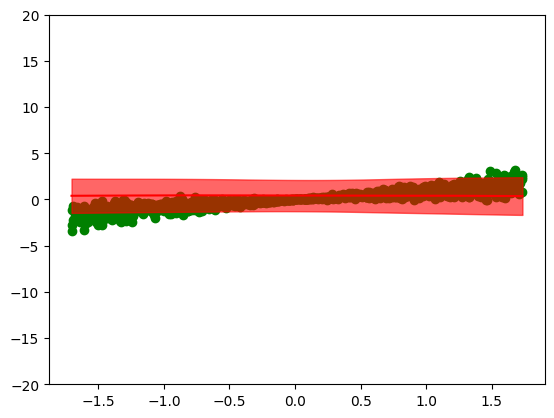

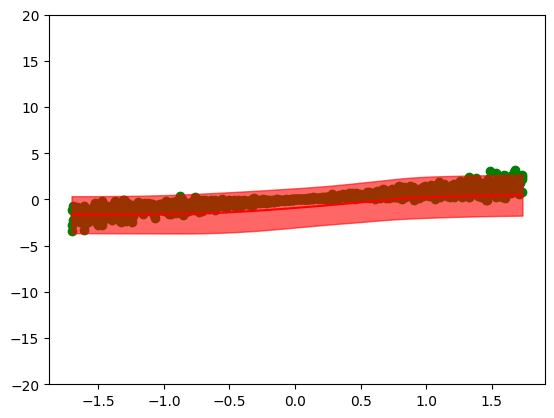

epoch=21/1000 | lr=(0.01000 (mu), 0.00100 (rho)) | loss=1204.89 = 1196.68 (nll) + 0.18 * 45.28 (kll) | ||mu|| = 6.31 | ||rho|| = 4.33
epoch=22/1000 | lr=(0.01000 (mu), 0.00100 (rho)) | loss=6717.95 = 6711.32 (nll) + 0.19 * 35.02 (kll) | ||mu|| = 6.31 | ||rho|| = 4.33
epoch=23/1000 | lr=(0.01000 (mu), 0.00100 (rho)) | loss=1423.28 = 1414.63 (nll) + 0.20 * 43.81 (kll) | ||mu|| = 6.31 | ||rho|| = 4.33
epoch=24/1000 | lr=(0.01000 (mu), 0.00100 (rho)) | loss=1078.10 = 1074.07 (nll) + 0.21 * 19.61 (kll) | ||mu|| = 6.32 | ||rho|| = 4.33
epoch=25/1000 | lr=(0.01000 (mu), 0.00100 (rho)) | loss=4429.92 = 4421.23 (nll) + 0.21 * 40.75 (kll) | ||mu|| = 6.32 | ||rho|| = 4.33
epoch=26/1000 | lr=(0.01000 (mu), 0.00100 (rho)) | loss=1182.65 = 1172.53 (nll) + 0.22 * 45.74 (kll) | ||mu|| = 6.32 | ||rho|| = 4.33
epoch=27/1000 | lr=(0.00100 (mu), 0.00100 (rho)) | loss=923.29 = 913.36 (nll) + 0.23 * 43.39 (kll) | ||mu|| = 6.32 | ||rho|| = 4.33
epoch=28/1000 | lr=(0.00100 (mu), 0.00100 (rho)) | loss=1503.09 

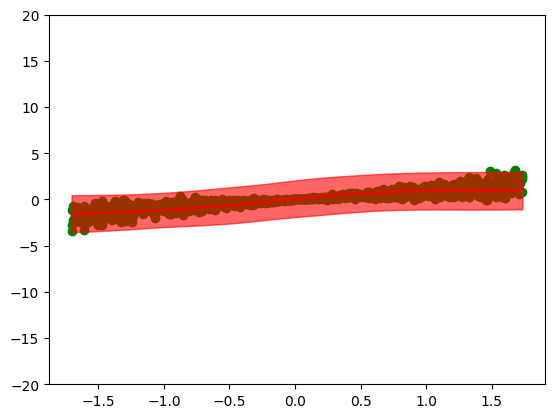

epoch=41/1000 | lr=(0.00010 (mu), 0.00001 (rho)) | loss=3887.45 = 3871.60 (nll) + 0.33 * 48.05 (kll) | ||mu|| = 6.32 | ||rho|| = 4.33
epoch=42/1000 | lr=(0.00010 (mu), 0.00001 (rho)) | loss=294.34 = 275.27 (nll) + 0.34 * 56.70 (kll) | ||mu|| = 6.32 | ||rho|| = 4.33
epoch=43/1000 | lr=(0.00010 (mu), 0.00001 (rho)) | loss=3060.58 = 3047.01 (nll) + 0.34 * 39.58 (kll) | ||mu|| = 6.32 | ||rho|| = 4.33
epoch=44/1000 | lr=(0.00010 (mu), 0.00001 (rho)) | loss=6575.63 = 6559.88 (nll) + 0.35 * 45.07 (kll) | ||mu|| = 6.32 | ||rho|| = 4.33
epoch=45/1000 | lr=(0.00010 (mu), 0.00001 (rho)) | loss=4540.23 = 4521.37 (nll) + 0.36 * 52.99 (kll) | ||mu|| = 6.32 | ||rho|| = 4.33
epoch=46/1000 | lr=(0.00001 (mu), 0.00001 (rho)) | loss=10839.74 = 10820.02 (nll) + 0.36 * 54.41 (kll) | ||mu|| = 6.32 | ||rho|| = 4.33
epoch=47/1000 | lr=(0.00001 (mu), 0.00001 (rho)) | loss=7720.75 = 7704.77 (nll) + 0.37 * 43.34 (kll) | ||mu|| = 6.32 | ||rho|| = 4.33
epoch=48/1000 | lr=(0.00001 (mu), 0.00001 (rho)) | loss=1559.1

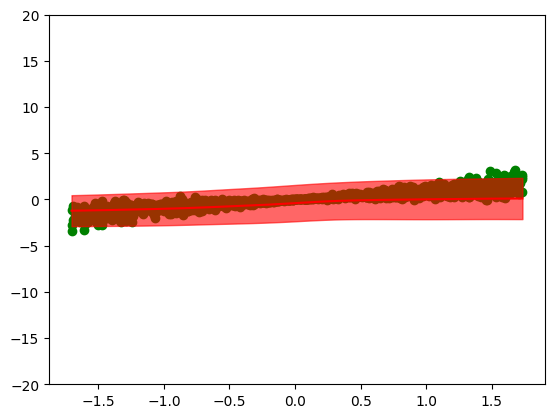

epoch=61/1000 | lr=(0.00001 (mu), 0.00001 (rho)) | loss=3603.28 = 3584.31 (nll) + 0.45 * 42.04 (kll) | ||mu|| = 6.32 | ||rho|| = 4.33
epoch=62/1000 | lr=(0.00001 (mu), 0.00001 (rho)) | loss=1718.16 = 1698.01 (nll) + 0.46 * 44.12 (kll) | ||mu|| = 6.32 | ||rho|| = 4.33
epoch=63/1000 | lr=(0.00001 (mu), 0.00001 (rho)) | loss=4881.47 = 4866.05 (nll) + 0.46 * 33.37 (kll) | ||mu|| = 6.32 | ||rho|| = 4.33
epoch=64/1000 | lr=(0.00001 (mu), 0.00001 (rho)) | loss=6347.82 = 6324.69 (nll) + 0.47 * 49.48 (kll) | ||mu|| = 6.32 | ||rho|| = 4.33
epoch=65/1000 | lr=(0.00001 (mu), 0.00001 (rho)) | loss=233.67 = 214.35 (nll) + 0.47 * 40.86 (kll) | ||mu|| = 6.32 | ||rho|| = 4.33
epoch=66/1000 | lr=(0.00001 (mu), 0.00001 (rho)) | loss=4489.23 = 4468.58 (nll) + 0.48 * 43.20 (kll) | ||mu|| = 6.32 | ||rho|| = 4.33
epoch=67/1000 | lr=(0.00001 (mu), 0.00001 (rho)) | loss=308.33 = 287.29 (nll) + 0.48 * 43.54 (kll) | ||mu|| = 6.32 | ||rho|| = 4.33
epoch=68/1000 | lr=(0.00001 (mu), 0.00001 (rho)) | loss=4205.30 = 

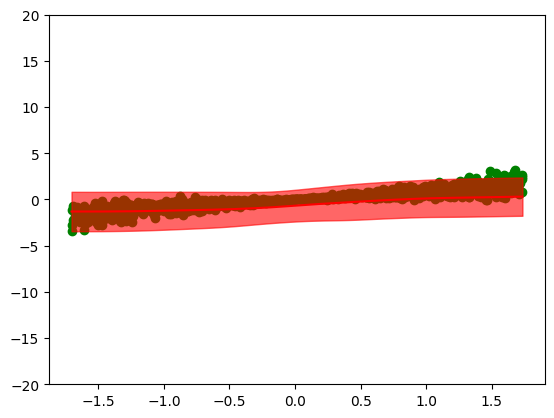

epoch=81/1000 | lr=(0.00001 (mu), 0.00001 (rho)) | loss=414.35 = 388.08 (nll) + 0.55 * 47.71 (kll) | ||mu|| = 6.32 | ||rho|| = 4.33
epoch=82/1000 | lr=(0.00001 (mu), 0.00001 (rho)) | loss=4040.79 = 4018.19 (nll) + 0.56 * 40.72 (kll) | ||mu|| = 6.32 | ||rho|| = 4.33
epoch=83/1000 | lr=(0.00001 (mu), 0.00001 (rho)) | loss=730.25 = 710.53 (nll) + 0.56 * 35.24 (kll) | ||mu|| = 6.32 | ||rho|| = 4.33
epoch=84/1000 | lr=(0.00001 (mu), 0.00001 (rho)) | loss=2742.41 = 2719.27 (nll) + 0.56 * 41.03 (kll) | ||mu|| = 6.32 | ||rho|| = 4.33
epoch=85/1000 | lr=(0.00001 (mu), 0.00001 (rho)) | loss=4474.60 = 4459.10 (nll) + 0.57 * 27.27 (kll) | ||mu|| = 6.32 | ||rho|| = 4.33
epoch=86/1000 | lr=(0.00001 (mu), 0.00001 (rho)) | loss=980.25 = 954.88 (nll) + 0.57 * 44.29 (kll) | ||mu|| = 6.32 | ||rho|| = 4.33
epoch=87/1000 | lr=(0.00001 (mu), 0.00001 (rho)) | loss=1385.62 = 1362.81 (nll) + 0.58 * 39.56 (kll) | ||mu|| = 6.32 | ||rho|| = 4.33
epoch=88/1000 | lr=(0.00001 (mu), 0.00001 (rho)) | loss=2288.19 = 22

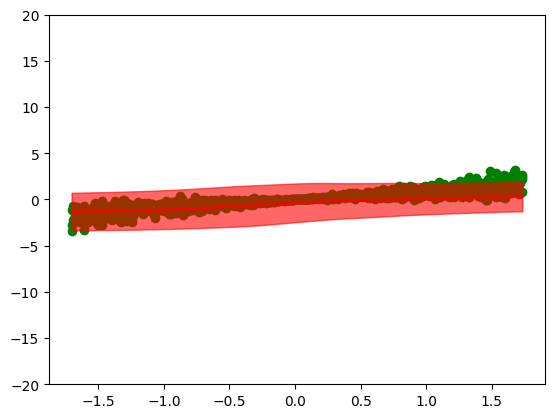

epoch=101/1000 | lr=(0.00001 (mu), 0.00001 (rho)) | loss=602.30 = 579.31 (nll) + 0.63 * 36.37 (kll) | ||mu|| = 6.32 | ||rho|| = 4.33
epoch=102/1000 | lr=(0.00001 (mu), 0.00001 (rho)) | loss=1931.82 = 1912.62 (nll) + 0.64 * 30.19 (kll) | ||mu|| = 6.32 | ||rho|| = 4.33
epoch=103/1000 | lr=(0.00001 (mu), 0.00001 (rho)) | loss=1284.38 = 1261.88 (nll) + 0.64 * 35.18 (kll) | ||mu|| = 6.32 | ||rho|| = 4.33
epoch=104/1000 | lr=(0.00001 (mu), 0.00001 (rho)) | loss=528.85 = 508.89 (nll) + 0.64 * 31.04 (kll) | ||mu|| = 6.32 | ||rho|| = 4.33
epoch=105/1000 | lr=(0.00001 (mu), 0.00001 (rho)) | loss=1236.85 = 1198.62 (nll) + 0.65 * 59.13 (kll) | ||mu|| = 6.32 | ||rho|| = 4.33
epoch=106/1000 | lr=(0.00001 (mu), 0.00001 (rho)) | loss=656.93 = 630.59 (nll) + 0.65 * 40.52 (kll) | ||mu|| = 6.32 | ||rho|| = 4.33
epoch=107/1000 | lr=(0.00001 (mu), 0.00001 (rho)) | loss=4275.84 = 4244.70 (nll) + 0.65 * 47.64 (kll) | ||mu|| = 6.32 | ||rho|| = 4.33
epoch=108/1000 | lr=(0.00001 (mu), 0.00001 (rho)) | loss=4064

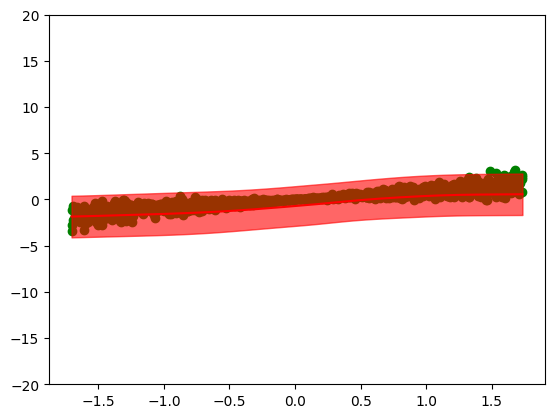

epoch=121/1000 | lr=(0.00001 (mu), 0.00001 (rho)) | loss=13599.64 = 13559.27 (nll) + 0.70 * 57.78 (kll) | ||mu|| = 6.32 | ||rho|| = 4.33
epoch=122/1000 | lr=(0.00001 (mu), 0.00001 (rho)) | loss=339.73 = 309.93 (nll) + 0.70 * 42.46 (kll) | ||mu|| = 6.32 | ||rho|| = 4.33
epoch=123/1000 | lr=(0.00001 (mu), 0.00001 (rho)) | loss=465.06 = 437.74 (nll) + 0.70 * 38.76 (kll) | ||mu|| = 6.32 | ||rho|| = 4.33
epoch=124/1000 | lr=(0.00001 (mu), 0.00001 (rho)) | loss=921.43 = 894.11 (nll) + 0.71 * 38.60 (kll) | ||mu|| = 6.32 | ||rho|| = 4.33
epoch=125/1000 | lr=(0.00001 (mu), 0.00001 (rho)) | loss=282.02 = 246.38 (nll) + 0.71 * 50.15 (kll) | ||mu|| = 6.32 | ||rho|| = 4.33
epoch=126/1000 | lr=(0.00001 (mu), 0.00001 (rho)) | loss=2091.61 = 2054.75 (nll) + 0.71 * 51.66 (kll) | ||mu|| = 6.32 | ||rho|| = 4.33
epoch=127/1000 | lr=(0.00001 (mu), 0.00001 (rho)) | loss=3547.28 = 3502.18 (nll) + 0.72 * 62.97 (kll) | ||mu|| = 6.32 | ||rho|| = 4.33
epoch=128/1000 | lr=(0.00001 (mu), 0.00001 (rho)) | loss=2858

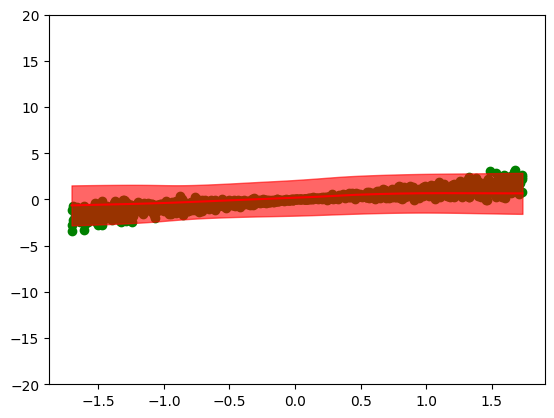

epoch=141/1000 | lr=(0.00001 (mu), 0.00001 (rho)) | loss=1537.15 = 1504.64 (nll) + 0.75 * 43.15 (kll) | ||mu|| = 6.32 | ||rho|| = 4.33
epoch=142/1000 | lr=(0.00001 (mu), 0.00001 (rho)) | loss=6147.42 = 6105.55 (nll) + 0.76 * 55.39 (kll) | ||mu|| = 6.32 | ||rho|| = 4.33
epoch=143/1000 | lr=(0.00001 (mu), 0.00001 (rho)) | loss=1510.57 = 1477.80 (nll) + 0.76 * 43.21 (kll) | ||mu|| = 6.32 | ||rho|| = 4.33
epoch=144/1000 | lr=(0.00001 (mu), 0.00001 (rho)) | loss=427.59 = 396.64 (nll) + 0.76 * 40.68 (kll) | ||mu|| = 6.32 | ||rho|| = 4.33
epoch=145/1000 | lr=(0.00001 (mu), 0.00001 (rho)) | loss=2133.12 = 2093.18 (nll) + 0.76 * 52.34 (kll) | ||mu|| = 6.32 | ||rho|| = 4.33
epoch=146/1000 | lr=(0.00001 (mu), 0.00001 (rho)) | loss=2367.14 = 2325.54 (nll) + 0.77 * 54.35 (kll) | ||mu|| = 6.32 | ||rho|| = 4.33
epoch=147/1000 | lr=(0.00001 (mu), 0.00001 (rho)) | loss=3810.66 = 3769.60 (nll) + 0.77 * 53.49 (kll) | ||mu|| = 6.32 | ||rho|| = 4.33
epoch=148/1000 | lr=(0.00001 (mu), 0.00001 (rho)) | loss=

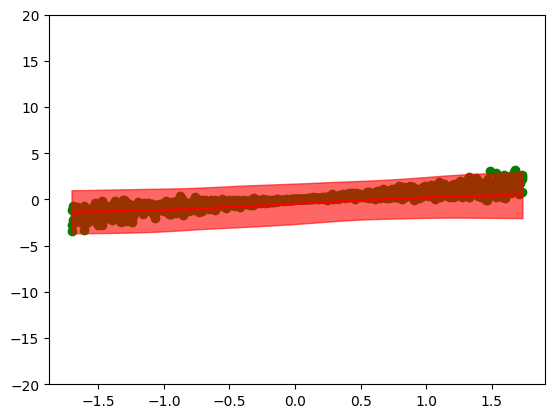

epoch=161/1000 | lr=(0.00001 (mu), 0.00001 (rho)) | loss=2191.81 = 2154.67 (nll) + 0.80 * 46.53 (kll) | ||mu|| = 6.32 | ||rho|| = 4.33
epoch=162/1000 | lr=(0.00001 (mu), 0.00001 (rho)) | loss=8354.12 = 8317.78 (nll) + 0.80 * 45.42 (kll) | ||mu|| = 6.32 | ||rho|| = 4.33
epoch=163/1000 | lr=(0.00001 (mu), 0.00001 (rho)) | loss=5898.02 = 5857.52 (nll) + 0.80 * 50.48 (kll) | ||mu|| = 6.32 | ||rho|| = 4.33
epoch=164/1000 | lr=(0.00001 (mu), 0.00001 (rho)) | loss=3699.12 = 3672.76 (nll) + 0.80 * 32.78 (kll) | ||mu|| = 6.32 | ||rho|| = 4.33
epoch=165/1000 | lr=(0.00001 (mu), 0.00001 (rho)) | loss=1185.36 = 1148.45 (nll) + 0.81 * 45.78 (kll) | ||mu|| = 6.32 | ||rho|| = 4.33
epoch=166/1000 | lr=(0.00001 (mu), 0.00001 (rho)) | loss=3697.21 = 3659.55 (nll) + 0.81 * 46.61 (kll) | ||mu|| = 6.32 | ||rho|| = 4.33
epoch=167/1000 | lr=(0.00001 (mu), 0.00001 (rho)) | loss=1329.26 = 1298.10 (nll) + 0.81 * 38.48 (kll) | ||mu|| = 6.32 | ||rho|| = 4.33
epoch=168/1000 | lr=(0.00001 (mu), 0.00001 (rho)) | los

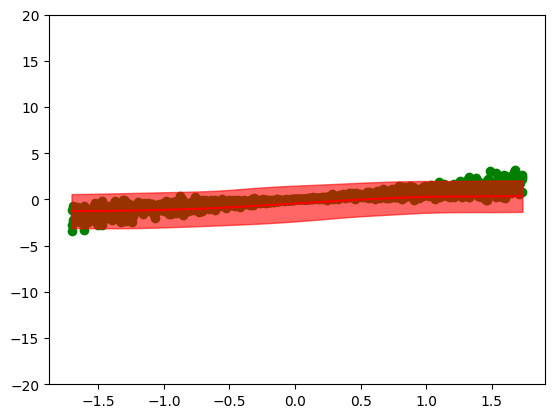

epoch=181/1000 | lr=(0.00001 (mu), 0.00001 (rho)) | loss=705.29 = 671.96 (nll) + 0.83 * 39.94 (kll) | ||mu|| = 6.32 | ||rho|| = 4.33
epoch=182/1000 | lr=(0.00001 (mu), 0.00001 (rho)) | loss=2419.42 = 2381.33 (nll) + 0.84 * 45.55 (kll) | ||mu|| = 6.32 | ||rho|| = 4.33
epoch=183/1000 | lr=(0.00001 (mu), 0.00001 (rho)) | loss=366.80 = 334.23 (nll) + 0.84 * 38.87 (kll) | ||mu|| = 6.32 | ||rho|| = 4.33
epoch=184/1000 | lr=(0.00001 (mu), 0.00001 (rho)) | loss=3381.33 = 3344.01 (nll) + 0.84 * 44.45 (kll) | ||mu|| = 6.32 | ||rho|| = 4.33
epoch=185/1000 | lr=(0.00001 (mu), 0.00001 (rho)) | loss=167.56 = 115.84 (nll) + 0.84 * 61.49 (kll) | ||mu|| = 6.32 | ||rho|| = 4.33
epoch=186/1000 | lr=(0.00001 (mu), 0.00001 (rho)) | loss=227.51 = 179.06 (nll) + 0.84 * 57.49 (kll) | ||mu|| = 6.32 | ||rho|| = 4.33
epoch=187/1000 | lr=(0.00001 (mu), 0.00001 (rho)) | loss=3053.25 = 3018.59 (nll) + 0.84 * 41.06 (kll) | ||mu|| = 6.32 | ||rho|| = 4.33
epoch=188/1000 | lr=(0.00001 (mu), 0.00001 (rho)) | loss=992.09

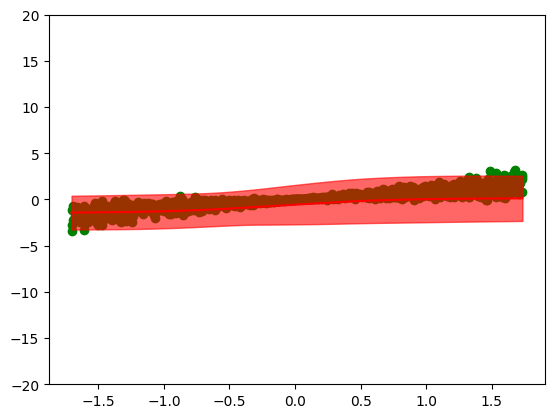

epoch=201/1000 | lr=(0.00001 (mu), 0.00001 (rho)) | loss=904.63 = 866.69 (nll) + 0.86 * 43.88 (kll) | ||mu|| = 6.32 | ||rho|| = 4.33
epoch=202/1000 | lr=(0.00001 (mu), 0.00001 (rho)) | loss=2697.45 = 2648.79 (nll) + 0.87 * 56.18 (kll) | ||mu|| = 6.32 | ||rho|| = 4.33
epoch=203/1000 | lr=(0.00001 (mu), 0.00001 (rho)) | loss=4018.98 = 3979.83 (nll) + 0.87 * 45.14 (kll) | ||mu|| = 6.32 | ||rho|| = 4.33
epoch=204/1000 | lr=(0.00001 (mu), 0.00001 (rho)) | loss=1309.09 = 1273.85 (nll) + 0.87 * 40.57 (kll) | ||mu|| = 6.32 | ||rho|| = 4.33
epoch=205/1000 | lr=(0.00001 (mu), 0.00001 (rho)) | loss=1384.19 = 1333.71 (nll) + 0.87 * 58.02 (kll) | ||mu|| = 6.32 | ||rho|| = 4.33
epoch=206/1000 | lr=(0.00001 (mu), 0.00001 (rho)) | loss=2189.07 = 2156.75 (nll) + 0.87 * 37.10 (kll) | ||mu|| = 6.32 | ||rho|| = 4.33
epoch=207/1000 | lr=(0.00001 (mu), 0.00001 (rho)) | loss=2106.80 = 2067.57 (nll) + 0.87 * 44.96 (kll) | ||mu|| = 6.32 | ||rho|| = 4.33
epoch=208/1000 | lr=(0.00001 (mu), 0.00001 (rho)) | loss=

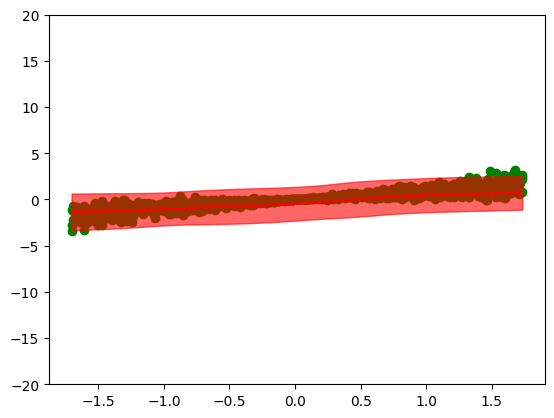

epoch=221/1000 | lr=(0.00001 (mu), 0.00001 (rho)) | loss=1273.42 = 1230.22 (nll) + 0.89 * 48.59 (kll) | ||mu|| = 6.32 | ||rho|| = 4.33
epoch=222/1000 | lr=(0.00001 (mu), 0.00001 (rho)) | loss=4113.48 = 4056.08 (nll) + 0.89 * 64.48 (kll) | ||mu|| = 6.32 | ||rho|| = 4.33
epoch=223/1000 | lr=(0.00001 (mu), 0.00001 (rho)) | loss=380.42 = 339.91 (nll) + 0.89 * 45.44 (kll) | ||mu|| = 6.32 | ||rho|| = 4.33
epoch=224/1000 | lr=(0.00001 (mu), 0.00001 (rho)) | loss=869.11 = 828.46 (nll) + 0.89 * 45.56 (kll) | ||mu|| = 6.32 | ||rho|| = 4.33
epoch=225/1000 | lr=(0.00001 (mu), 0.00001 (rho)) | loss=3444.46 = 3399.13 (nll) + 0.89 * 50.73 (kll) | ||mu|| = 6.32 | ||rho|| = 4.33
epoch=226/1000 | lr=(0.00001 (mu), 0.00001 (rho)) | loss=1648.63 = 1612.43 (nll) + 0.89 * 40.47 (kll) | ||mu|| = 6.32 | ||rho|| = 4.33
epoch=227/1000 | lr=(0.00001 (mu), 0.00001 (rho)) | loss=4055.69 = 4015.48 (nll) + 0.90 * 44.90 (kll) | ||mu|| = 6.32 | ||rho|| = 4.33
epoch=228/1000 | lr=(0.00001 (mu), 0.00001 (rho)) | loss=11

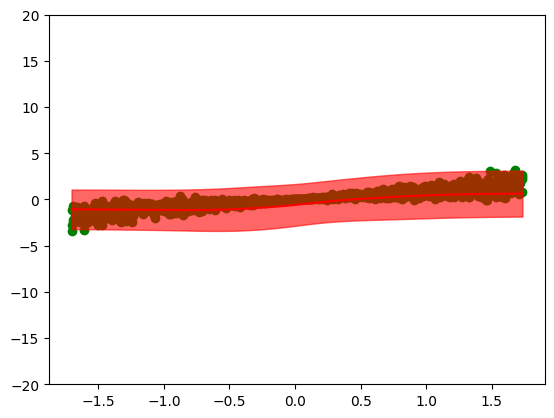

epoch=241/1000 | lr=(0.00001 (mu), 0.00001 (rho)) | loss=497.58 = 448.90 (nll) + 0.91 * 53.53 (kll) | ||mu|| = 6.32 | ||rho|| = 4.33
epoch=242/1000 | lr=(0.00001 (mu), 0.00001 (rho)) | loss=775.29 = 741.09 (nll) + 0.91 * 37.58 (kll) | ||mu|| = 6.32 | ||rho|| = 4.33
epoch=243/1000 | lr=(0.00001 (mu), 0.00001 (rho)) | loss=406.24 = 374.51 (nll) + 0.91 * 34.83 (kll) | ||mu|| = 6.32 | ||rho|| = 4.33
epoch=244/1000 | lr=(0.00001 (mu), 0.00001 (rho)) | loss=1688.30 = 1637.86 (nll) + 0.91 * 55.31 (kll) | ||mu|| = 6.32 | ||rho|| = 4.33
epoch=245/1000 | lr=(0.00001 (mu), 0.00001 (rho)) | loss=2171.89 = 2136.74 (nll) + 0.91 * 38.51 (kll) | ||mu|| = 6.32 | ||rho|| = 4.33
epoch=246/1000 | lr=(0.00001 (mu), 0.00001 (rho)) | loss=258.99 = 213.92 (nll) + 0.91 * 49.33 (kll) | ||mu|| = 6.32 | ||rho|| = 4.33
epoch=247/1000 | lr=(0.00001 (mu), 0.00001 (rho)) | loss=1722.44 = 1699.01 (nll) + 0.91 * 25.62 (kll) | ||mu|| = 6.32 | ||rho|| = 4.33
epoch=248/1000 | lr=(0.00001 (mu), 0.00001 (rho)) | loss=1199.7

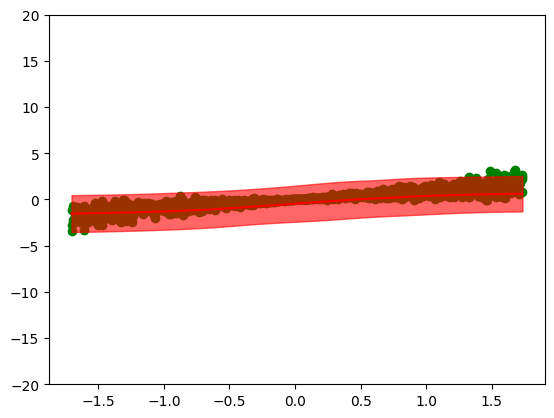

epoch=261/1000 | lr=(0.00001 (mu), 0.00001 (rho)) | loss=6484.08 = 6430.27 (nll) + 0.93 * 58.13 (kll) | ||mu|| = 6.32 | ||rho|| = 4.33
epoch=262/1000 | lr=(0.00001 (mu), 0.00001 (rho)) | loss=3676.41 = 3630.77 (nll) + 0.93 * 49.26 (kll) | ||mu|| = 6.32 | ||rho|| = 4.33
epoch=263/1000 | lr=(0.00001 (mu), 0.00001 (rho)) | loss=2359.71 = 2313.21 (nll) + 0.93 * 50.15 (kll) | ||mu|| = 6.32 | ||rho|| = 4.33
epoch=264/1000 | lr=(0.00001 (mu), 0.00001 (rho)) | loss=1402.20 = 1366.53 (nll) + 0.93 * 38.44 (kll) | ||mu|| = 6.32 | ||rho|| = 4.33
epoch=265/1000 | lr=(0.00001 (mu), 0.00001 (rho)) | loss=1597.27 = 1562.87 (nll) + 0.93 * 37.05 (kll) | ||mu|| = 6.32 | ||rho|| = 4.33
epoch=266/1000 | lr=(0.00001 (mu), 0.00001 (rho)) | loss=5595.07 = 5552.91 (nll) + 0.93 * 45.37 (kll) | ||mu|| = 6.32 | ||rho|| = 4.33
epoch=267/1000 | lr=(0.00001 (mu), 0.00001 (rho)) | loss=1912.44 = 1873.95 (nll) + 0.93 * 41.39 (kll) | ||mu|| = 6.32 | ||rho|| = 4.33
epoch=268/1000 | lr=(0.00001 (mu), 0.00001 (rho)) | los

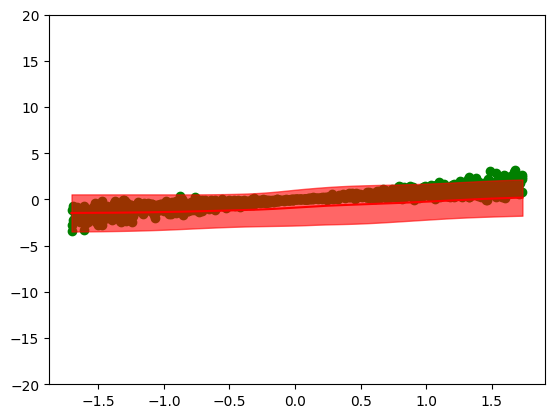

epoch=281/1000 | lr=(0.00001 (mu), 0.00001 (rho)) | loss=2218.05 = 2197.15 (nll) + 0.94 * 22.26 (kll) | ||mu|| = 6.32 | ||rho|| = 4.33
epoch=282/1000 | lr=(0.00001 (mu), 0.00001 (rho)) | loss=347.60 = 305.13 (nll) + 0.94 * 45.19 (kll) | ||mu|| = 6.32 | ||rho|| = 4.33
epoch=283/1000 | lr=(0.00001 (mu), 0.00001 (rho)) | loss=1043.21 = 1000.79 (nll) + 0.94 * 45.11 (kll) | ||mu|| = 6.32 | ||rho|| = 4.33
epoch=284/1000 | lr=(0.00001 (mu), 0.00001 (rho)) | loss=5350.96 = 5312.09 (nll) + 0.94 * 41.30 (kll) | ||mu|| = 6.32 | ||rho|| = 4.33
epoch=285/1000 | lr=(0.00001 (mu), 0.00001 (rho)) | loss=3126.76 = 3091.51 (nll) + 0.94 * 37.44 (kll) | ||mu|| = 6.32 | ||rho|| = 4.33
epoch=286/1000 | lr=(0.00001 (mu), 0.00001 (rho)) | loss=1610.42 = 1568.95 (nll) + 0.94 * 44.01 (kll) | ||mu|| = 6.32 | ||rho|| = 4.33
epoch=287/1000 | lr=(0.00001 (mu), 0.00001 (rho)) | loss=1541.99 = 1489.49 (nll) + 0.94 * 55.69 (kll) | ||mu|| = 6.32 | ||rho|| = 4.33
epoch=288/1000 | lr=(0.00001 (mu), 0.00001 (rho)) | loss=

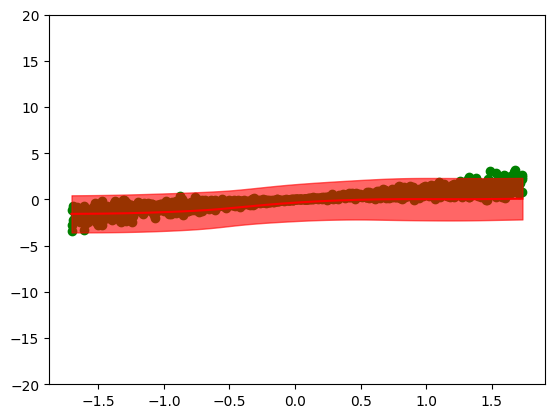

epoch=301/1000 | lr=(0.00001 (mu), 0.00001 (rho)) | loss=1520.89 = 1487.84 (nll) + 0.95 * 34.79 (kll) | ||mu|| = 6.32 | ||rho|| = 4.33
epoch=302/1000 | lr=(0.00001 (mu), 0.00001 (rho)) | loss=1547.56 = 1501.00 (nll) + 0.95 * 48.98 (kll) | ||mu|| = 6.32 | ||rho|| = 4.33
epoch=303/1000 | lr=(0.00001 (mu), 0.00001 (rho)) | loss=341.89 = 295.81 (nll) + 0.95 * 48.44 (kll) | ||mu|| = 6.32 | ||rho|| = 4.33
epoch=304/1000 | lr=(0.00001 (mu), 0.00001 (rho)) | loss=322.49 = 272.80 (nll) + 0.95 * 52.22 (kll) | ||mu|| = 6.32 | ||rho|| = 4.33
epoch=305/1000 | lr=(0.00001 (mu), 0.00001 (rho)) | loss=1016.59 = 980.01 (nll) + 0.95 * 38.41 (kll) | ||mu|| = 6.32 | ||rho|| = 4.33
epoch=306/1000 | lr=(0.00001 (mu), 0.00001 (rho)) | loss=1639.79 = 1596.33 (nll) + 0.95 * 45.63 (kll) | ||mu|| = 6.32 | ||rho|| = 4.33
epoch=307/1000 | lr=(0.00001 (mu), 0.00001 (rho)) | loss=4427.02 = 4394.96 (nll) + 0.95 * 33.64 (kll) | ||mu|| = 6.32 | ||rho|| = 4.33
epoch=308/1000 | lr=(0.00001 (mu), 0.00001 (rho)) | loss=264

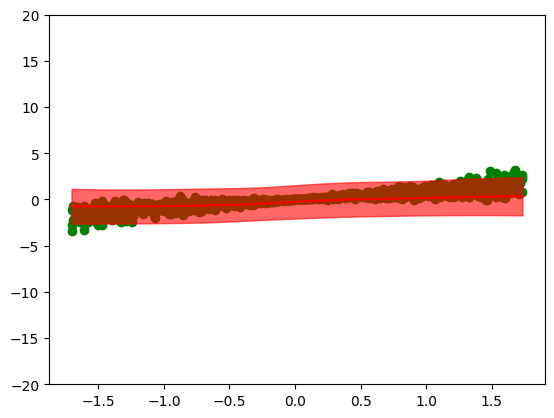

epoch=321/1000 | lr=(0.00001 (mu), 0.00001 (rho)) | loss=5592.65 = 5546.49 (nll) + 0.96 * 48.13 (kll) | ||mu|| = 6.32 | ||rho|| = 4.33
epoch=322/1000 | lr=(0.00001 (mu), 0.00001 (rho)) | loss=778.62 = 738.26 (nll) + 0.96 * 42.06 (kll) | ||mu|| = 6.32 | ||rho|| = 4.33
epoch=323/1000 | lr=(0.00001 (mu), 0.00001 (rho)) | loss=885.71 = 842.05 (nll) + 0.96 * 45.48 (kll) | ||mu|| = 6.32 | ||rho|| = 4.33
epoch=324/1000 | lr=(0.00001 (mu), 0.00001 (rho)) | loss=517.87 = 479.67 (nll) + 0.96 * 39.77 (kll) | ||mu|| = 6.32 | ||rho|| = 4.33
epoch=325/1000 | lr=(0.00001 (mu), 0.00001 (rho)) | loss=4021.17 = 3991.82 (nll) + 0.96 * 30.54 (kll) | ||mu|| = 6.32 | ||rho|| = 4.33
epoch=326/1000 | lr=(0.00001 (mu), 0.00001 (rho)) | loss=8347.45 = 8298.73 (nll) + 0.96 * 50.69 (kll) | ||mu|| = 6.32 | ||rho|| = 4.33
epoch=327/1000 | lr=(0.00001 (mu), 0.00001 (rho)) | loss=1611.85 = 1575.09 (nll) + 0.96 * 38.23 (kll) | ||mu|| = 6.32 | ||rho|| = 4.33
epoch=328/1000 | lr=(0.00001 (mu), 0.00001 (rho)) | loss=6840

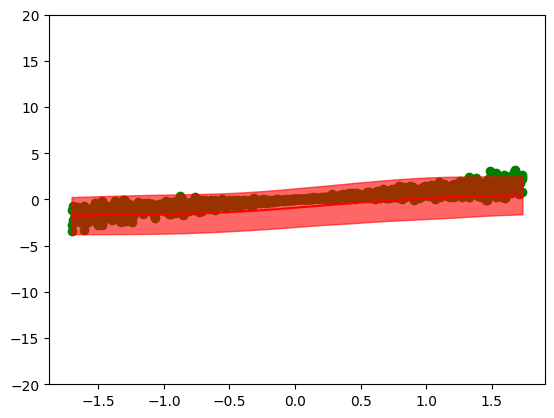

epoch=341/1000 | lr=(0.00001 (mu), 0.00001 (rho)) | loss=1729.34 = 1678.22 (nll) + 0.97 * 52.89 (kll) | ||mu|| = 6.32 | ||rho|| = 4.33
epoch=342/1000 | lr=(0.00001 (mu), 0.00001 (rho)) | loss=3553.02 = 3498.73 (nll) + 0.97 * 56.15 (kll) | ||mu|| = 6.32 | ||rho|| = 4.33
epoch=343/1000 | lr=(0.00001 (mu), 0.00001 (rho)) | loss=12846.49 = 12798.80 (nll) + 0.97 * 49.30 (kll) | ||mu|| = 6.32 | ||rho|| = 4.33
epoch=344/1000 | lr=(0.00001 (mu), 0.00001 (rho)) | loss=1471.82 = 1441.09 (nll) + 0.97 * 31.76 (kll) | ||mu|| = 6.32 | ||rho|| = 4.33
epoch=345/1000 | lr=(0.00001 (mu), 0.00001 (rho)) | loss=1193.46 = 1149.93 (nll) + 0.97 * 44.97 (kll) | ||mu|| = 6.32 | ||rho|| = 4.33
epoch=346/1000 | lr=(0.00001 (mu), 0.00001 (rho)) | loss=352.19 = 300.82 (nll) + 0.97 * 53.06 (kll) | ||mu|| = 6.32 | ||rho|| = 4.33
epoch=347/1000 | lr=(0.00001 (mu), 0.00001 (rho)) | loss=1466.52 = 1415.40 (nll) + 0.97 * 52.78 (kll) | ||mu|| = 6.32 | ||rho|| = 4.33
epoch=348/1000 | lr=(0.00001 (mu), 0.00001 (rho)) | los

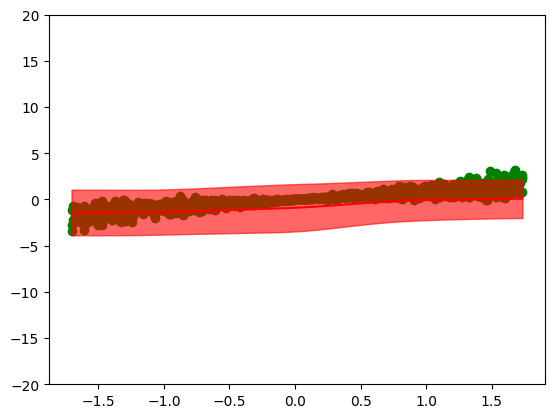

epoch=361/1000 | lr=(0.00001 (mu), 0.00001 (rho)) | loss=1207.61 = 1162.22 (nll) + 0.97 * 46.67 (kll) | ||mu|| = 6.32 | ||rho|| = 4.33
epoch=362/1000 | lr=(0.00001 (mu), 0.00001 (rho)) | loss=9955.23 = 9893.17 (nll) + 0.97 * 63.78 (kll) | ||mu|| = 6.32 | ||rho|| = 4.33
epoch=363/1000 | lr=(0.00001 (mu), 0.00001 (rho)) | loss=1497.65 = 1447.07 (nll) + 0.97 * 51.97 (kll) | ||mu|| = 6.32 | ||rho|| = 4.33
epoch=364/1000 | lr=(0.00001 (mu), 0.00001 (rho)) | loss=9912.88 = 9863.91 (nll) + 0.97 * 50.31 (kll) | ||mu|| = 6.32 | ||rho|| = 4.33
epoch=365/1000 | lr=(0.00001 (mu), 0.00001 (rho)) | loss=6051.77 = 5998.59 (nll) + 0.97 * 54.61 (kll) | ||mu|| = 6.32 | ||rho|| = 4.33
epoch=366/1000 | lr=(0.00001 (mu), 0.00001 (rho)) | loss=2873.48 = 2833.56 (nll) + 0.97 * 40.99 (kll) | ||mu|| = 6.32 | ||rho|| = 4.33
epoch=367/1000 | lr=(0.00001 (mu), 0.00001 (rho)) | loss=946.58 = 882.27 (nll) + 0.97 * 66.02 (kll) | ||mu|| = 6.32 | ||rho|| = 4.33
epoch=368/1000 | lr=(0.00001 (mu), 0.00001 (rho)) | loss=

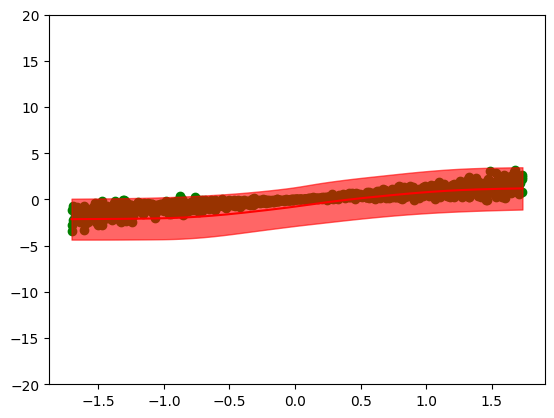

epoch=381/1000 | lr=(0.00001 (mu), 0.00001 (rho)) | loss=1734.99 = 1673.39 (nll) + 0.98 * 63.02 (kll) | ||mu|| = 6.32 | ||rho|| = 4.33
epoch=382/1000 | lr=(0.00001 (mu), 0.00001 (rho)) | loss=6887.41 = 6835.89 (nll) + 0.98 * 52.68 (kll) | ||mu|| = 6.32 | ||rho|| = 4.33
epoch=383/1000 | lr=(0.00001 (mu), 0.00001 (rho)) | loss=397.17 = 361.23 (nll) + 0.98 * 36.74 (kll) | ||mu|| = 6.32 | ||rho|| = 4.33
epoch=384/1000 | lr=(0.00001 (mu), 0.00001 (rho)) | loss=713.34 = 660.12 (nll) + 0.98 * 54.41 (kll) | ||mu|| = 6.32 | ||rho|| = 4.33
epoch=385/1000 | lr=(0.00001 (mu), 0.00001 (rho)) | loss=2134.41 = 2101.43 (nll) + 0.98 * 33.71 (kll) | ||mu|| = 6.32 | ||rho|| = 4.33
epoch=386/1000 | lr=(0.00001 (mu), 0.00001 (rho)) | loss=2352.92 = 2304.80 (nll) + 0.98 * 49.17 (kll) | ||mu|| = 6.32 | ||rho|| = 4.33
epoch=387/1000 | lr=(0.00001 (mu), 0.00001 (rho)) | loss=2043.97 = 2004.38 (nll) + 0.98 * 40.45 (kll) | ||mu|| = 6.32 | ||rho|| = 4.33
epoch=388/1000 | lr=(0.00001 (mu), 0.00001 (rho)) | loss=25

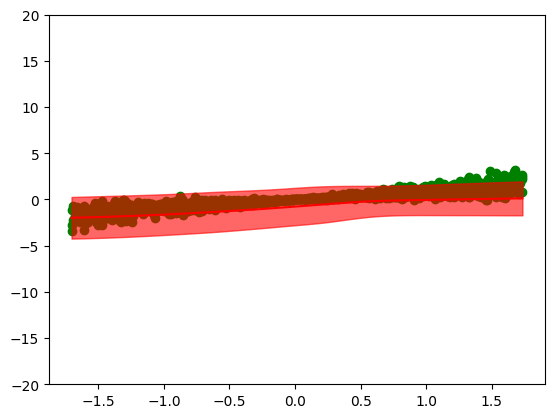

epoch=401/1000 | lr=(0.00001 (mu), 0.00001 (rho)) | loss=6915.28 = 6870.89 (nll) + 0.98 * 45.22 (kll) | ||mu|| = 6.32 | ||rho|| = 4.33
epoch=402/1000 | lr=(0.00001 (mu), 0.00001 (rho)) | loss=859.56 = 817.30 (nll) + 0.98 * 43.04 (kll) | ||mu|| = 6.32 | ||rho|| = 4.33
epoch=403/1000 | lr=(0.00001 (mu), 0.00001 (rho)) | loss=1138.97 = 1106.54 (nll) + 0.98 * 33.02 (kll) | ||mu|| = 6.32 | ||rho|| = 4.33
epoch=404/1000 | lr=(0.00001 (mu), 0.00001 (rho)) | loss=1035.69 = 982.59 (nll) + 0.98 * 54.07 (kll) | ||mu|| = 6.32 | ||rho|| = 4.33
epoch=405/1000 | lr=(0.00001 (mu), 0.00001 (rho)) | loss=691.88 = 652.40 (nll) + 0.98 * 40.19 (kll) | ||mu|| = 6.32 | ||rho|| = 4.33
epoch=406/1000 | lr=(0.00001 (mu), 0.00001 (rho)) | loss=10547.32 = 10486.29 (nll) + 0.98 * 62.11 (kll) | ||mu|| = 6.32 | ||rho|| = 4.33
epoch=407/1000 | lr=(0.00001 (mu), 0.00001 (rho)) | loss=1339.04 = 1290.44 (nll) + 0.98 * 49.45 (kll) | ||mu|| = 6.32 | ||rho|| = 4.33
epoch=408/1000 | lr=(0.00001 (mu), 0.00001 (rho)) | loss=6

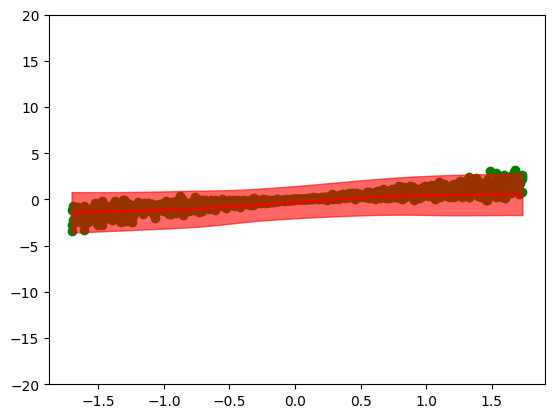

epoch=421/1000 | lr=(0.00001 (mu), 0.00001 (rho)) | loss=838.55 = 797.25 (nll) + 0.99 * 41.93 (kll) | ||mu|| = 6.32 | ||rho|| = 4.33
epoch=422/1000 | lr=(0.00001 (mu), 0.00001 (rho)) | loss=1596.06 = 1550.73 (nll) + 0.99 * 46.01 (kll) | ||mu|| = 6.32 | ||rho|| = 4.33
epoch=423/1000 | lr=(0.00001 (mu), 0.00001 (rho)) | loss=2768.72 = 2741.19 (nll) + 0.99 * 27.94 (kll) | ||mu|| = 6.32 | ||rho|| = 4.33
epoch=424/1000 | lr=(0.00001 (mu), 0.00001 (rho)) | loss=2169.23 = 2126.06 (nll) + 0.99 * 43.81 (kll) | ||mu|| = 6.32 | ||rho|| = 4.33
epoch=425/1000 | lr=(0.00001 (mu), 0.00001 (rho)) | loss=7329.27 = 7286.27 (nll) + 0.99 * 43.62 (kll) | ||mu|| = 6.32 | ||rho|| = 4.33
epoch=426/1000 | lr=(0.00001 (mu), 0.00001 (rho)) | loss=1055.99 = 1016.45 (nll) + 0.99 * 40.11 (kll) | ||mu|| = 6.32 | ||rho|| = 4.33
epoch=427/1000 | lr=(0.00001 (mu), 0.00001 (rho)) | loss=1583.47 = 1546.12 (nll) + 0.99 * 37.89 (kll) | ||mu|| = 6.32 | ||rho|| = 4.33
epoch=428/1000 | lr=(0.00001 (mu), 0.00001 (rho)) | loss=

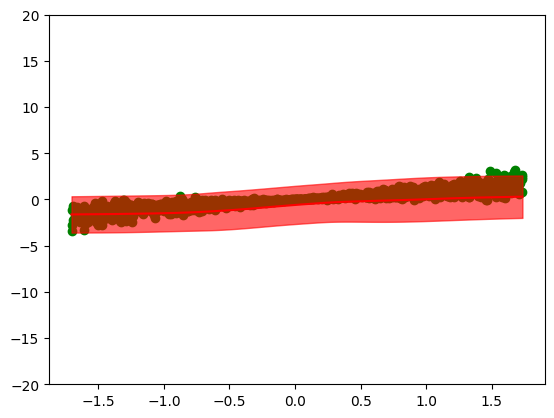

epoch=441/1000 | lr=(0.00001 (mu), 0.00001 (rho)) | loss=507.06 = 461.46 (nll) + 0.99 * 46.16 (kll) | ||mu|| = 6.32 | ||rho|| = 4.33
epoch=442/1000 | lr=(0.00001 (mu), 0.00001 (rho)) | loss=899.25 = 844.55 (nll) + 0.99 * 55.37 (kll) | ||mu|| = 6.32 | ||rho|| = 4.33
epoch=443/1000 | lr=(0.00001 (mu), 0.00001 (rho)) | loss=2045.06 = 2014.54 (nll) + 0.99 * 30.89 (kll) | ||mu|| = 6.32 | ||rho|| = 4.33
epoch=444/1000 | lr=(0.00001 (mu), 0.00001 (rho)) | loss=1279.56 = 1226.86 (nll) + 0.99 * 53.33 (kll) | ||mu|| = 6.32 | ||rho|| = 4.33
epoch=445/1000 | lr=(0.00001 (mu), 0.00001 (rho)) | loss=2680.89 = 2646.89 (nll) + 0.99 * 34.41 (kll) | ||mu|| = 6.32 | ||rho|| = 4.33
epoch=446/1000 | lr=(0.00001 (mu), 0.00001 (rho)) | loss=6413.66 = 6348.28 (nll) + 0.99 * 66.15 (kll) | ||mu|| = 6.32 | ||rho|| = 4.33
epoch=447/1000 | lr=(0.00001 (mu), 0.00001 (rho)) | loss=4567.83 = 4509.95 (nll) + 0.99 * 58.56 (kll) | ||mu|| = 6.32 | ||rho|| = 4.33
epoch=448/1000 | lr=(0.00001 (mu), 0.00001 (rho)) | loss=46

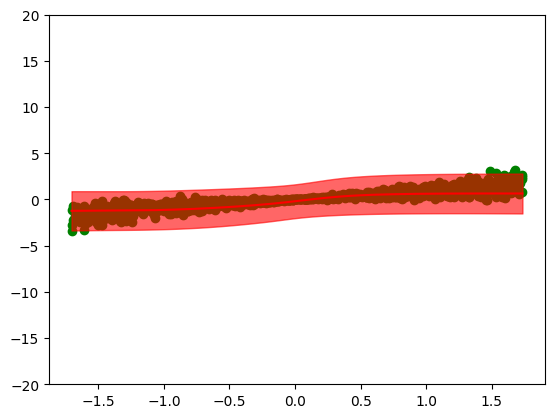

epoch=461/1000 | lr=(0.00001 (mu), 0.00001 (rho)) | loss=1523.13 = 1476.39 (nll) + 0.99 * 47.22 (kll) | ||mu|| = 6.32 | ||rho|| = 4.33
epoch=462/1000 | lr=(0.00001 (mu), 0.00001 (rho)) | loss=927.43 = 884.90 (nll) + 0.99 * 42.96 (kll) | ||mu|| = 6.32 | ||rho|| = 4.33
epoch=463/1000 | lr=(0.00001 (mu), 0.00001 (rho)) | loss=2996.11 = 2954.28 (nll) + 0.99 * 42.25 (kll) | ||mu|| = 6.32 | ||rho|| = 4.33
epoch=464/1000 | lr=(0.00001 (mu), 0.00001 (rho)) | loss=505.71 = 471.84 (nll) + 0.99 * 34.20 (kll) | ||mu|| = 6.32 | ||rho|| = 4.33
epoch=465/1000 | lr=(0.00001 (mu), 0.00001 (rho)) | loss=867.47 = 838.05 (nll) + 0.99 * 29.70 (kll) | ||mu|| = 6.32 | ||rho|| = 4.33
epoch=466/1000 | lr=(0.00001 (mu), 0.00001 (rho)) | loss=1967.08 = 1915.81 (nll) + 0.99 * 51.77 (kll) | ||mu|| = 6.32 | ||rho|| = 4.33
epoch=467/1000 | lr=(0.00001 (mu), 0.00001 (rho)) | loss=1816.26 = 1781.83 (nll) + 0.99 * 34.75 (kll) | ||mu|| = 6.32 | ||rho|| = 4.33
epoch=468/1000 | lr=(0.00001 (mu), 0.00001 (rho)) | loss=4006

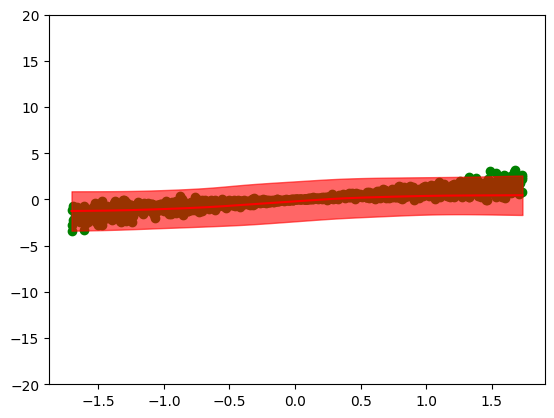

epoch=481/1000 | lr=(0.00001 (mu), 0.00001 (rho)) | loss=4207.37 = 4151.73 (nll) + 0.99 * 56.10 (kll) | ||mu|| = 6.32 | ||rho|| = 4.33
epoch=482/1000 | lr=(0.00001 (mu), 0.00001 (rho)) | loss=1385.17 = 1343.55 (nll) + 0.99 * 41.96 (kll) | ||mu|| = 6.32 | ||rho|| = 4.33
epoch=483/1000 | lr=(0.00001 (mu), 0.00001 (rho)) | loss=1563.61 = 1524.02 (nll) + 0.99 * 39.90 (kll) | ||mu|| = 6.32 | ||rho|| = 4.33
epoch=484/1000 | lr=(0.00001 (mu), 0.00001 (rho)) | loss=2946.22 = 2904.24 (nll) + 0.99 * 42.31 (kll) | ||mu|| = 6.32 | ||rho|| = 4.33
epoch=485/1000 | lr=(0.00001 (mu), 0.00001 (rho)) | loss=802.27 = 741.94 (nll) + 0.99 * 60.81 (kll) | ||mu|| = 6.32 | ||rho|| = 4.33
epoch=486/1000 | lr=(0.00001 (mu), 0.00001 (rho)) | loss=257.45 = 217.23 (nll) + 0.99 * 40.53 (kll) | ||mu|| = 6.32 | ||rho|| = 4.33
epoch=487/1000 | lr=(0.00001 (mu), 0.00001 (rho)) | loss=627.34 = 574.84 (nll) + 0.99 * 52.91 (kll) | ||mu|| = 6.32 | ||rho|| = 4.33
epoch=488/1000 | lr=(0.00001 (mu), 0.00001 (rho)) | loss=1385

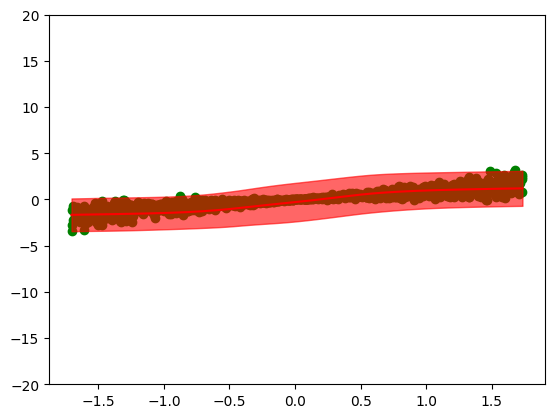

epoch=501/1000 | lr=(0.00001 (mu), 0.00001 (rho)) | loss=575.39 = 528.64 (nll) + 0.99 * 47.07 (kll) | ||mu|| = 6.32 | ||rho|| = 4.33
epoch=502/1000 | lr=(0.00001 (mu), 0.00001 (rho)) | loss=4884.78 = 4838.65 (nll) + 0.99 * 46.44 (kll) | ||mu|| = 6.32 | ||rho|| = 4.33
epoch=503/1000 | lr=(0.00001 (mu), 0.00001 (rho)) | loss=942.18 = 913.08 (nll) + 0.99 * 29.29 (kll) | ||mu|| = 6.32 | ||rho|| = 4.33
epoch=504/1000 | lr=(0.00001 (mu), 0.00001 (rho)) | loss=259.28 = 205.92 (nll) + 0.99 * 53.71 (kll) | ||mu|| = 6.32 | ||rho|| = 4.33
epoch=505/1000 | lr=(0.00001 (mu), 0.00001 (rho)) | loss=1788.38 = 1733.90 (nll) + 0.99 * 54.84 (kll) | ||mu|| = 6.32 | ||rho|| = 4.33
epoch=506/1000 | lr=(0.00001 (mu), 0.00001 (rho)) | loss=594.95 = 543.47 (nll) + 0.99 * 51.81 (kll) | ||mu|| = 6.32 | ||rho|| = 4.33
epoch=507/1000 | lr=(0.00001 (mu), 0.00001 (rho)) | loss=465.52 = 429.10 (nll) + 0.99 * 36.65 (kll) | ||mu|| = 6.32 | ||rho|| = 4.33
epoch=508/1000 | lr=(0.00001 (mu), 0.00001 (rho)) | loss=3039.31 

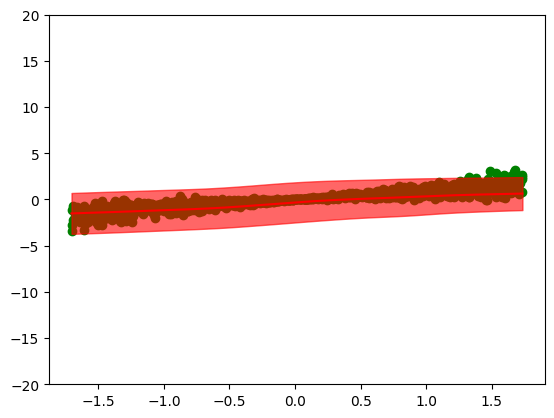

epoch=521/1000 | lr=(0.00001 (mu), 0.00001 (rho)) | loss=1478.97 = 1434.06 (nll) + 0.99 * 45.15 (kll) | ||mu|| = 6.32 | ||rho|| = 4.33
epoch=522/1000 | lr=(0.00001 (mu), 0.00001 (rho)) | loss=938.56 = 894.01 (nll) + 0.99 * 44.79 (kll) | ||mu|| = 6.32 | ||rho|| = 4.33
epoch=523/1000 | lr=(0.00001 (mu), 0.00001 (rho)) | loss=2123.10 = 2088.63 (nll) + 0.99 * 34.65 (kll) | ||mu|| = 6.32 | ||rho|| = 4.33
epoch=524/1000 | lr=(0.00001 (mu), 0.00001 (rho)) | loss=1278.17 = 1237.36 (nll) + 0.99 * 41.03 (kll) | ||mu|| = 6.32 | ||rho|| = 4.33
epoch=525/1000 | lr=(0.00001 (mu), 0.00001 (rho)) | loss=1228.11 = 1187.13 (nll) + 0.99 * 41.19 (kll) | ||mu|| = 6.32 | ||rho|| = 4.33
epoch=526/1000 | lr=(0.00001 (mu), 0.00001 (rho)) | loss=7128.98 = 7089.78 (nll) + 0.99 * 39.41 (kll) | ||mu|| = 6.32 | ||rho|| = 4.33
epoch=527/1000 | lr=(0.00001 (mu), 0.00001 (rho)) | loss=4248.88 = 4182.21 (nll) + 0.99 * 67.02 (kll) | ||mu|| = 6.32 | ||rho|| = 4.33
epoch=528/1000 | lr=(0.00001 (mu), 0.00001 (rho)) | loss=

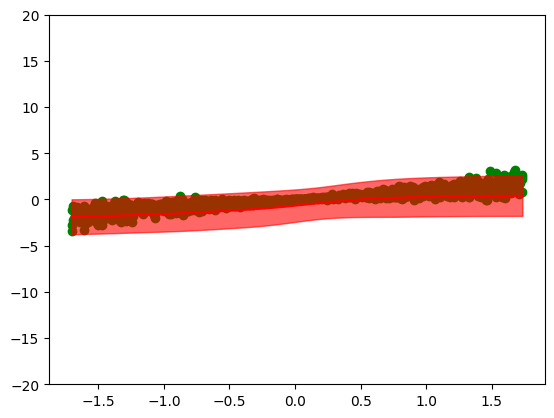

epoch=541/1000 | lr=(0.00001 (mu), 0.00001 (rho)) | loss=1658.50 = 1618.51 (nll) + 1.00 * 40.17 (kll) | ||mu|| = 6.32 | ||rho|| = 4.33
epoch=542/1000 | lr=(0.00001 (mu), 0.00001 (rho)) | loss=4140.31 = 4101.07 (nll) + 1.00 * 39.42 (kll) | ||mu|| = 6.32 | ||rho|| = 4.33
epoch=543/1000 | lr=(0.00001 (mu), 0.00001 (rho)) | loss=2260.47 = 2213.46 (nll) + 1.00 * 47.21 (kll) | ||mu|| = 6.32 | ||rho|| = 4.33
epoch=544/1000 | lr=(0.00001 (mu), 0.00001 (rho)) | loss=1148.53 = 1115.77 (nll) + 1.00 * 32.90 (kll) | ||mu|| = 6.32 | ||rho|| = 4.33
epoch=545/1000 | lr=(0.00001 (mu), 0.00001 (rho)) | loss=1297.47 = 1242.18 (nll) + 1.00 * 55.53 (kll) | ||mu|| = 6.32 | ||rho|| = 4.33
epoch=546/1000 | lr=(0.00001 (mu), 0.00001 (rho)) | loss=1464.64 = 1423.94 (nll) + 1.00 * 40.88 (kll) | ||mu|| = 6.32 | ||rho|| = 4.33
epoch=547/1000 | lr=(0.00001 (mu), 0.00001 (rho)) | loss=435.44 = 387.77 (nll) + 1.00 * 47.87 (kll) | ||mu|| = 6.32 | ||rho|| = 4.33
epoch=548/1000 | lr=(0.00001 (mu), 0.00001 (rho)) | loss=

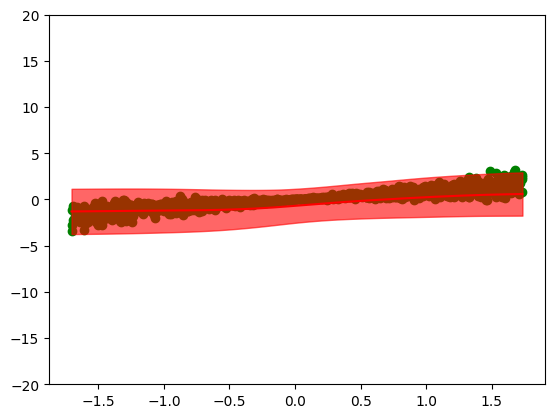

epoch=561/1000 | lr=(0.00001 (mu), 0.00001 (rho)) | loss=3604.34 = 3558.48 (nll) + 1.00 * 46.02 (kll) | ||mu|| = 6.32 | ||rho|| = 4.33
epoch=562/1000 | lr=(0.00001 (mu), 0.00001 (rho)) | loss=541.61 = 505.56 (nll) + 1.00 * 36.19 (kll) | ||mu|| = 6.32 | ||rho|| = 4.33
epoch=563/1000 | lr=(0.00001 (mu), 0.00001 (rho)) | loss=807.45 = 756.54 (nll) + 1.00 * 51.10 (kll) | ||mu|| = 6.32 | ||rho|| = 4.33
epoch=564/1000 | lr=(0.00001 (mu), 0.00001 (rho)) | loss=2330.42 = 2279.37 (nll) + 1.00 * 51.23 (kll) | ||mu|| = 6.32 | ||rho|| = 4.33
epoch=565/1000 | lr=(0.00001 (mu), 0.00001 (rho)) | loss=1734.87 = 1696.96 (nll) + 1.00 * 38.05 (kll) | ||mu|| = 6.32 | ||rho|| = 4.33
epoch=566/1000 | lr=(0.00001 (mu), 0.00001 (rho)) | loss=1560.19 = 1521.11 (nll) + 1.00 * 39.22 (kll) | ||mu|| = 6.32 | ||rho|| = 4.33
epoch=567/1000 | lr=(0.00001 (mu), 0.00001 (rho)) | loss=1194.58 = 1149.46 (nll) + 1.00 * 45.28 (kll) | ||mu|| = 6.32 | ||rho|| = 4.33
epoch=568/1000 | lr=(0.00001 (mu), 0.00001 (rho)) | loss=60

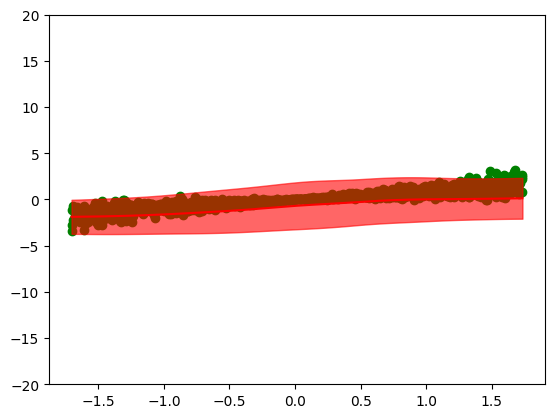

epoch=581/1000 | lr=(0.00001 (mu), 0.00001 (rho)) | loss=819.17 = 774.55 (nll) + 1.00 * 44.76 (kll) | ||mu|| = 6.32 | ||rho|| = 4.33
epoch=582/1000 | lr=(0.00001 (mu), 0.00001 (rho)) | loss=1284.30 = 1233.14 (nll) + 1.00 * 51.31 (kll) | ||mu|| = 6.32 | ||rho|| = 4.33
epoch=583/1000 | lr=(0.00001 (mu), 0.00001 (rho)) | loss=2802.11 = 2760.70 (nll) + 1.00 * 41.54 (kll) | ||mu|| = 6.32 | ||rho|| = 4.33
epoch=584/1000 | lr=(0.00001 (mu), 0.00001 (rho)) | loss=468.79 = 426.79 (nll) + 1.00 * 42.13 (kll) | ||mu|| = 6.32 | ||rho|| = 4.33
epoch=585/1000 | lr=(0.00001 (mu), 0.00001 (rho)) | loss=2637.09 = 2581.74 (nll) + 1.00 * 55.52 (kll) | ||mu|| = 6.32 | ||rho|| = 4.33
epoch=586/1000 | lr=(0.00001 (mu), 0.00001 (rho)) | loss=2385.24 = 2348.41 (nll) + 1.00 * 36.94 (kll) | ||mu|| = 6.32 | ||rho|| = 4.33
epoch=587/1000 | lr=(0.00001 (mu), 0.00001 (rho)) | loss=6849.58 = 6804.61 (nll) + 1.00 * 45.10 (kll) | ||mu|| = 6.32 | ||rho|| = 4.33
epoch=588/1000 | lr=(0.00001 (mu), 0.00001 (rho)) | loss=12

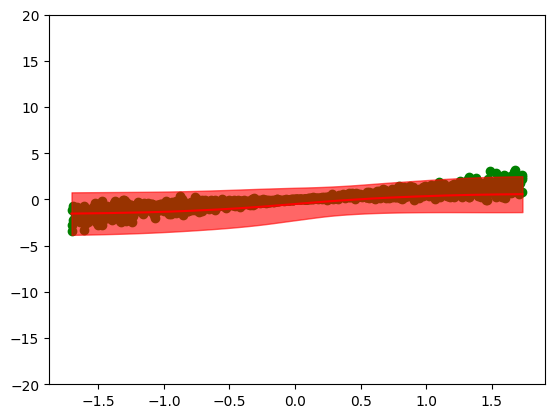

epoch=601/1000 | lr=(0.00001 (mu), 0.00001 (rho)) | loss=3513.41 = 3484.99 (nll) + 1.00 * 28.50 (kll) | ||mu|| = 6.32 | ||rho|| = 4.33
epoch=602/1000 | lr=(0.00001 (mu), 0.00001 (rho)) | loss=1674.13 = 1632.40 (nll) + 1.00 * 41.83 (kll) | ||mu|| = 6.32 | ||rho|| = 4.33
epoch=603/1000 | lr=(0.00001 (mu), 0.00001 (rho)) | loss=5431.33 = 5389.18 (nll) + 1.00 * 42.25 (kll) | ||mu|| = 6.32 | ||rho|| = 4.33
epoch=604/1000 | lr=(0.00001 (mu), 0.00001 (rho)) | loss=1781.61 = 1730.84 (nll) + 1.00 * 50.90 (kll) | ||mu|| = 6.32 | ||rho|| = 4.33
epoch=605/1000 | lr=(0.00001 (mu), 0.00001 (rho)) | loss=4904.29 = 4863.28 (nll) + 1.00 * 41.12 (kll) | ||mu|| = 6.32 | ||rho|| = 4.33
epoch=606/1000 | lr=(0.00001 (mu), 0.00001 (rho)) | loss=3319.68 = 3269.15 (nll) + 1.00 * 50.65 (kll) | ||mu|| = 6.32 | ||rho|| = 4.33
epoch=607/1000 | lr=(0.00001 (mu), 0.00001 (rho)) | loss=1321.67 = 1278.70 (nll) + 1.00 * 43.06 (kll) | ||mu|| = 6.32 | ||rho|| = 4.33
epoch=608/1000 | lr=(0.00001 (mu), 0.00001 (rho)) | los

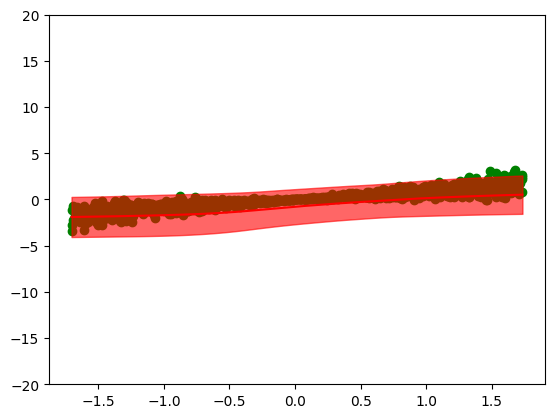

epoch=621/1000 | lr=(0.00001 (mu), 0.00001 (rho)) | loss=295.69 = 249.73 (nll) + 1.00 * 46.06 (kll) | ||mu|| = 6.32 | ||rho|| = 4.33
epoch=622/1000 | lr=(0.00001 (mu), 0.00001 (rho)) | loss=1174.45 = 1135.15 (nll) + 1.00 * 39.38 (kll) | ||mu|| = 6.32 | ||rho|| = 4.33
epoch=623/1000 | lr=(0.00001 (mu), 0.00001 (rho)) | loss=9546.95 = 9508.27 (nll) + 1.00 * 38.75 (kll) | ||mu|| = 6.32 | ||rho|| = 4.33
epoch=624/1000 | lr=(0.00001 (mu), 0.00001 (rho)) | loss=2355.28 = 2292.96 (nll) + 1.00 * 62.44 (kll) | ||mu|| = 6.32 | ||rho|| = 4.33
epoch=625/1000 | lr=(0.00001 (mu), 0.00001 (rho)) | loss=1103.99 = 1041.91 (nll) + 1.00 * 62.21 (kll) | ||mu|| = 6.32 | ||rho|| = 4.33
epoch=626/1000 | lr=(0.00001 (mu), 0.00001 (rho)) | loss=3186.22 = 3142.94 (nll) + 1.00 * 43.36 (kll) | ||mu|| = 6.32 | ||rho|| = 4.33
epoch=627/1000 | lr=(0.00001 (mu), 0.00001 (rho)) | loss=3289.07 = 3235.18 (nll) + 1.00 * 54.00 (kll) | ||mu|| = 6.32 | ||rho|| = 4.33
epoch=628/1000 | lr=(0.00001 (mu), 0.00001 (rho)) | loss=

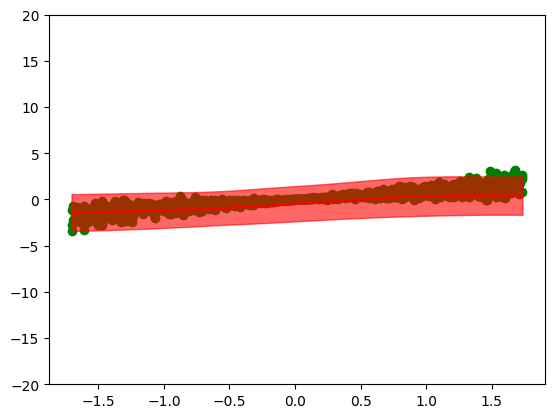

epoch=641/1000 | lr=(0.00001 (mu), 0.00001 (rho)) | loss=3116.80 = 3071.72 (nll) + 1.00 * 45.15 (kll) | ||mu|| = 6.32 | ||rho|| = 4.33
epoch=642/1000 | lr=(0.00001 (mu), 0.00001 (rho)) | loss=1086.61 = 1049.14 (nll) + 1.00 * 37.53 (kll) | ||mu|| = 6.32 | ||rho|| = 4.33
epoch=643/1000 | lr=(0.00001 (mu), 0.00001 (rho)) | loss=805.75 = 771.31 (nll) + 1.00 * 34.49 (kll) | ||mu|| = 6.32 | ||rho|| = 4.33
epoch=644/1000 | lr=(0.00001 (mu), 0.00001 (rho)) | loss=5213.48 = 5168.98 (nll) + 1.00 * 44.57 (kll) | ||mu|| = 6.32 | ||rho|| = 4.33
epoch=645/1000 | lr=(0.00001 (mu), 0.00001 (rho)) | loss=1452.66 = 1403.85 (nll) + 1.00 * 48.89 (kll) | ||mu|| = 6.32 | ||rho|| = 4.33
epoch=646/1000 | lr=(0.00001 (mu), 0.00001 (rho)) | loss=1150.58 = 1108.95 (nll) + 1.00 * 41.69 (kll) | ||mu|| = 6.32 | ||rho|| = 4.33
epoch=647/1000 | lr=(0.00001 (mu), 0.00001 (rho)) | loss=209.06 = 175.41 (nll) + 1.00 * 33.71 (kll) | ||mu|| = 6.32 | ||rho|| = 4.33
epoch=648/1000 | lr=(0.00001 (mu), 0.00001 (rho)) | loss=24

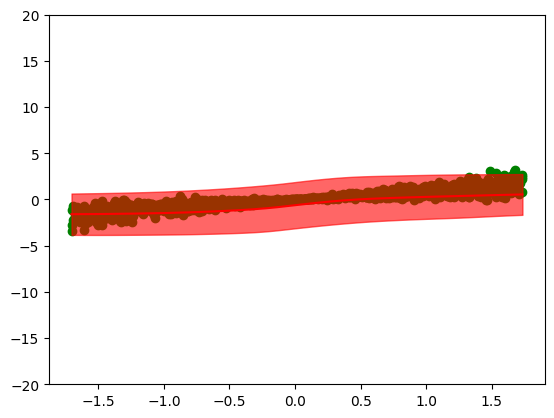

epoch=661/1000 | lr=(0.00001 (mu), 0.00001 (rho)) | loss=3140.95 = 3083.44 (nll) + 1.00 * 57.59 (kll) | ||mu|| = 6.32 | ||rho|| = 4.33
epoch=662/1000 | lr=(0.00001 (mu), 0.00001 (rho)) | loss=1174.88 = 1134.19 (nll) + 1.00 * 40.75 (kll) | ||mu|| = 6.32 | ||rho|| = 4.33
epoch=663/1000 | lr=(0.00001 (mu), 0.00001 (rho)) | loss=1971.14 = 1918.12 (nll) + 1.00 * 53.10 (kll) | ||mu|| = 6.32 | ||rho|| = 4.33
epoch=664/1000 | lr=(0.00001 (mu), 0.00001 (rho)) | loss=1074.42 = 1026.09 (nll) + 1.00 * 48.40 (kll) | ||mu|| = 6.32 | ||rho|| = 4.33
epoch=665/1000 | lr=(0.00001 (mu), 0.00001 (rho)) | loss=4166.75 = 4113.85 (nll) + 1.00 * 52.97 (kll) | ||mu|| = 6.32 | ||rho|| = 4.33
epoch=666/1000 | lr=(0.00001 (mu), 0.00001 (rho)) | loss=1243.36 = 1202.33 (nll) + 1.00 * 41.07 (kll) | ||mu|| = 6.32 | ||rho|| = 4.33
epoch=667/1000 | lr=(0.00001 (mu), 0.00001 (rho)) | loss=5550.39 = 5498.84 (nll) + 1.00 * 51.62 (kll) | ||mu|| = 6.32 | ||rho|| = 4.33
epoch=668/1000 | lr=(0.00001 (mu), 0.00001 (rho)) | los

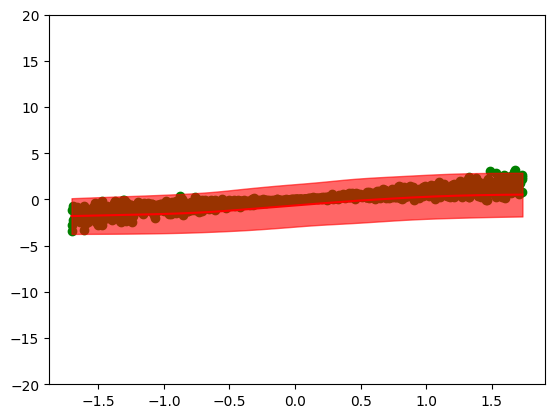

epoch=681/1000 | lr=(0.00001 (mu), 0.00001 (rho)) | loss=1683.26 = 1638.63 (nll) + 1.00 * 44.68 (kll) | ||mu|| = 6.32 | ||rho|| = 4.33
epoch=682/1000 | lr=(0.00001 (mu), 0.00001 (rho)) | loss=5933.39 = 5886.76 (nll) + 1.00 * 46.68 (kll) | ||mu|| = 6.32 | ||rho|| = 4.33
epoch=683/1000 | lr=(0.00001 (mu), 0.00001 (rho)) | loss=2116.75 = 2079.20 (nll) + 1.00 * 37.59 (kll) | ||mu|| = 6.32 | ||rho|| = 4.33
epoch=684/1000 | lr=(0.00001 (mu), 0.00001 (rho)) | loss=268.29 = 210.35 (nll) + 1.00 * 58.00 (kll) | ||mu|| = 6.32 | ||rho|| = 4.33
epoch=685/1000 | lr=(0.00001 (mu), 0.00001 (rho)) | loss=1399.05 = 1357.15 (nll) + 1.00 * 41.95 (kll) | ||mu|| = 6.32 | ||rho|| = 4.33
epoch=686/1000 | lr=(0.00001 (mu), 0.00001 (rho)) | loss=1275.56 = 1236.70 (nll) + 1.00 * 38.90 (kll) | ||mu|| = 6.32 | ||rho|| = 4.33
epoch=687/1000 | lr=(0.00001 (mu), 0.00001 (rho)) | loss=938.19 = 898.07 (nll) + 1.00 * 40.17 (kll) | ||mu|| = 6.32 | ||rho|| = 4.33
epoch=688/1000 | lr=(0.00001 (mu), 0.00001 (rho)) | loss=45

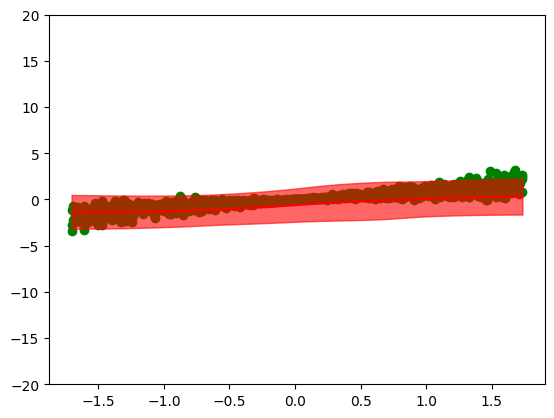

epoch=701/1000 | lr=(0.00001 (mu), 0.00001 (rho)) | loss=1892.50 = 1858.59 (nll) + 1.00 * 33.94 (kll) | ||mu|| = 6.32 | ||rho|| = 4.33
epoch=702/1000 | lr=(0.00001 (mu), 0.00001 (rho)) | loss=3753.62 = 3722.02 (nll) + 1.00 * 31.63 (kll) | ||mu|| = 6.32 | ||rho|| = 4.33
epoch=703/1000 | lr=(0.00001 (mu), 0.00001 (rho)) | loss=1158.61 = 1103.99 (nll) + 1.00 * 54.67 (kll) | ||mu|| = 6.32 | ||rho|| = 4.33
epoch=704/1000 | lr=(0.00001 (mu), 0.00001 (rho)) | loss=5685.61 = 5636.06 (nll) + 1.00 * 49.59 (kll) | ||mu|| = 6.32 | ||rho|| = 4.33
epoch=705/1000 | lr=(0.00001 (mu), 0.00001 (rho)) | loss=5102.76 = 5046.14 (nll) + 1.00 * 56.67 (kll) | ||mu|| = 6.32 | ||rho|| = 4.33
epoch=706/1000 | lr=(0.00001 (mu), 0.00001 (rho)) | loss=2402.04 = 2356.26 (nll) + 1.00 * 45.83 (kll) | ||mu|| = 6.32 | ||rho|| = 4.33
epoch=707/1000 | lr=(0.00001 (mu), 0.00001 (rho)) | loss=1748.88 = 1705.87 (nll) + 1.00 * 43.05 (kll) | ||mu|| = 6.32 | ||rho|| = 4.33
epoch=708/1000 | lr=(0.00001 (mu), 0.00001 (rho)) | los

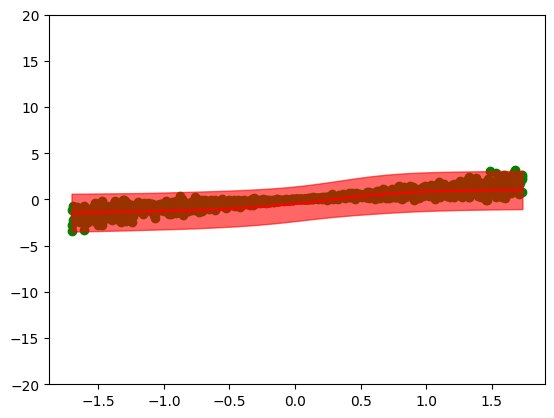

epoch=721/1000 | lr=(0.00001 (mu), 0.00001 (rho)) | loss=2109.37 = 2068.23 (nll) + 1.00 * 41.18 (kll) | ||mu|| = 6.32 | ||rho|| = 4.33
epoch=722/1000 | lr=(0.00001 (mu), 0.00001 (rho)) | loss=180.30 = 123.98 (nll) + 1.00 * 56.36 (kll) | ||mu|| = 6.32 | ||rho|| = 4.33
epoch=723/1000 | lr=(0.00001 (mu), 0.00001 (rho)) | loss=4745.84 = 4689.03 (nll) + 1.00 * 56.86 (kll) | ||mu|| = 6.32 | ||rho|| = 4.33
epoch=724/1000 | lr=(0.00001 (mu), 0.00001 (rho)) | loss=10434.25 = 10389.26 (nll) + 1.00 * 45.03 (kll) | ||mu|| = 6.32 | ||rho|| = 4.33
epoch=725/1000 | lr=(0.00001 (mu), 0.00001 (rho)) | loss=3056.07 = 3006.71 (nll) + 1.00 * 49.40 (kll) | ||mu|| = 6.32 | ||rho|| = 4.33
epoch=726/1000 | lr=(0.00001 (mu), 0.00001 (rho)) | loss=12658.32 = 12611.57 (nll) + 1.00 * 46.79 (kll) | ||mu|| = 6.32 | ||rho|| = 4.33
epoch=727/1000 | lr=(0.00001 (mu), 0.00001 (rho)) | loss=1474.98 = 1420.85 (nll) + 1.00 * 54.17 (kll) | ||mu|| = 6.32 | ||rho|| = 4.33
epoch=728/1000 | lr=(0.00001 (mu), 0.00001 (rho)) | l

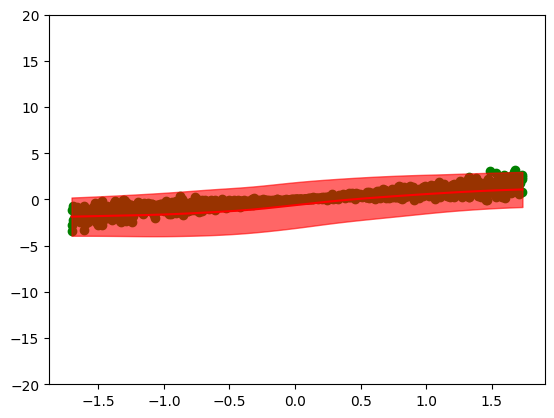

epoch=741/1000 | lr=(0.00001 (mu), 0.00001 (rho)) | loss=1986.99 = 1935.17 (nll) + 1.00 * 51.86 (kll) | ||mu|| = 6.32 | ||rho|| = 4.33
epoch=742/1000 | lr=(0.00001 (mu), 0.00001 (rho)) | loss=860.66 = 814.55 (nll) + 1.00 * 46.14 (kll) | ||mu|| = 6.32 | ||rho|| = 4.33
epoch=743/1000 | lr=(0.00001 (mu), 0.00001 (rho)) | loss=6506.71 = 6460.02 (nll) + 1.00 * 46.72 (kll) | ||mu|| = 6.32 | ||rho|| = 4.33
epoch=744/1000 | lr=(0.00001 (mu), 0.00001 (rho)) | loss=407.53 = 358.11 (nll) + 1.00 * 49.45 (kll) | ||mu|| = 6.32 | ||rho|| = 4.33
epoch=745/1000 | lr=(0.00001 (mu), 0.00001 (rho)) | loss=1938.50 = 1906.75 (nll) + 1.00 * 31.77 (kll) | ||mu|| = 6.32 | ||rho|| = 4.33
epoch=746/1000 | lr=(0.00001 (mu), 0.00001 (rho)) | loss=518.32 = 474.19 (nll) + 1.00 * 44.15 (kll) | ||mu|| = 6.32 | ||rho|| = 4.33
epoch=747/1000 | lr=(0.00001 (mu), 0.00001 (rho)) | loss=2313.13 = 2262.71 (nll) + 1.00 * 50.45 (kll) | ||mu|| = 6.32 | ||rho|| = 4.33
epoch=748/1000 | lr=(0.00001 (mu), 0.00001 (rho)) | loss=483.

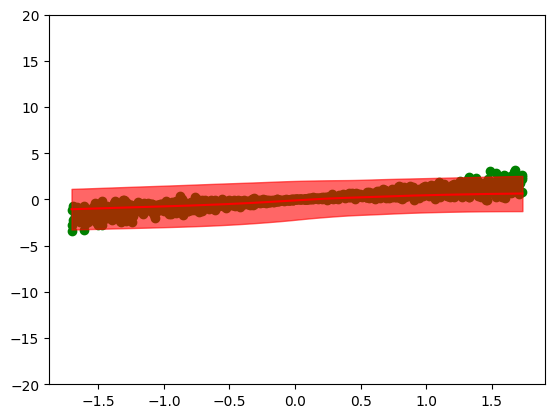

epoch=761/1000 | lr=(0.00001 (mu), 0.00001 (rho)) | loss=1608.50 = 1557.04 (nll) + 1.00 * 51.49 (kll) | ||mu|| = 6.32 | ||rho|| = 4.33
epoch=762/1000 | lr=(0.00001 (mu), 0.00001 (rho)) | loss=4282.49 = 4239.38 (nll) + 1.00 * 43.14 (kll) | ||mu|| = 6.32 | ||rho|| = 4.33
epoch=763/1000 | lr=(0.00001 (mu), 0.00001 (rho)) | loss=4850.93 = 4786.03 (nll) + 1.00 * 64.92 (kll) | ||mu|| = 6.32 | ||rho|| = 4.33
epoch=764/1000 | lr=(0.00001 (mu), 0.00001 (rho)) | loss=4793.58 = 4743.60 (nll) + 1.00 * 50.00 (kll) | ||mu|| = 6.32 | ||rho|| = 4.33
epoch=765/1000 | lr=(0.00001 (mu), 0.00001 (rho)) | loss=2074.08 = 2050.70 (nll) + 1.00 * 23.39 (kll) | ||mu|| = 6.32 | ||rho|| = 4.33
epoch=766/1000 | lr=(0.00001 (mu), 0.00001 (rho)) | loss=339.64 = 291.72 (nll) + 1.00 * 47.94 (kll) | ||mu|| = 6.32 | ||rho|| = 4.33
epoch=767/1000 | lr=(0.00001 (mu), 0.00001 (rho)) | loss=1373.76 = 1324.24 (nll) + 1.00 * 49.54 (kll) | ||mu|| = 6.32 | ||rho|| = 4.33
epoch=768/1000 | lr=(0.00001 (mu), 0.00001 (rho)) | loss=

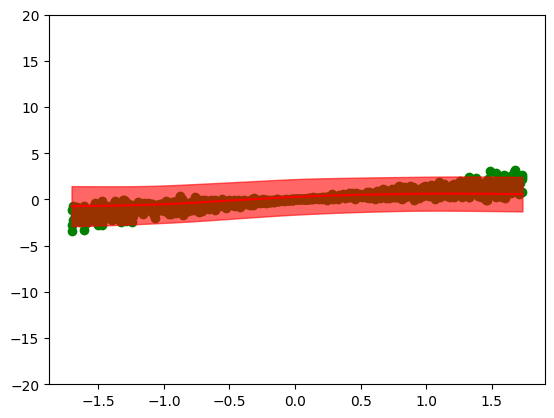

epoch=781/1000 | lr=(0.00001 (mu), 0.00001 (rho)) | loss=4923.49 = 4874.18 (nll) + 1.00 * 49.33 (kll) | ||mu|| = 6.32 | ||rho|| = 4.33
epoch=782/1000 | lr=(0.00001 (mu), 0.00001 (rho)) | loss=4475.41 = 4417.98 (nll) + 1.00 * 57.46 (kll) | ||mu|| = 6.32 | ||rho|| = 4.33
epoch=783/1000 | lr=(0.00001 (mu), 0.00001 (rho)) | loss=1054.25 = 1013.63 (nll) + 1.00 * 40.64 (kll) | ||mu|| = 6.32 | ||rho|| = 4.33
epoch=784/1000 | lr=(0.00001 (mu), 0.00001 (rho)) | loss=1356.89 = 1314.70 (nll) + 1.00 * 42.21 (kll) | ||mu|| = 6.32 | ||rho|| = 4.33
epoch=785/1000 | lr=(0.00001 (mu), 0.00001 (rho)) | loss=650.98 = 615.29 (nll) + 1.00 * 35.70 (kll) | ||mu|| = 6.32 | ||rho|| = 4.33
epoch=786/1000 | lr=(0.00001 (mu), 0.00001 (rho)) | loss=444.13 = 388.48 (nll) + 1.00 * 55.68 (kll) | ||mu|| = 6.32 | ||rho|| = 4.33
epoch=787/1000 | lr=(0.00001 (mu), 0.00001 (rho)) | loss=1982.57 = 1939.01 (nll) + 1.00 * 43.58 (kll) | ||mu|| = 6.32 | ||rho|| = 4.33
epoch=788/1000 | lr=(0.00001 (mu), 0.00001 (rho)) | loss=56

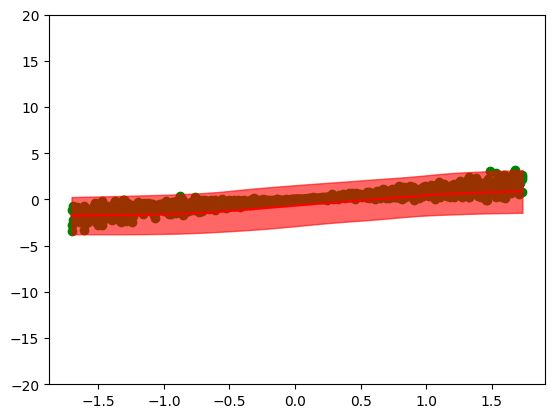

epoch=801/1000 | lr=(0.00001 (mu), 0.00001 (rho)) | loss=3737.23 = 3693.08 (nll) + 1.00 * 44.16 (kll) | ||mu|| = 6.32 | ||rho|| = 4.33
epoch=802/1000 | lr=(0.00001 (mu), 0.00001 (rho)) | loss=413.42 = 355.41 (nll) + 1.00 * 58.03 (kll) | ||mu|| = 6.32 | ||rho|| = 4.33
epoch=803/1000 | lr=(0.00001 (mu), 0.00001 (rho)) | loss=2353.50 = 2299.34 (nll) + 1.00 * 54.18 (kll) | ||mu|| = 6.32 | ||rho|| = 4.33
epoch=804/1000 | lr=(0.00001 (mu), 0.00001 (rho)) | loss=1201.59 = 1158.18 (nll) + 1.00 * 43.42 (kll) | ||mu|| = 6.32 | ||rho|| = 4.33
epoch=805/1000 | lr=(0.00001 (mu), 0.00001 (rho)) | loss=3886.02 = 3840.18 (nll) + 1.00 * 45.86 (kll) | ||mu|| = 6.32 | ||rho|| = 4.33
epoch=806/1000 | lr=(0.00001 (mu), 0.00001 (rho)) | loss=301.18 = 257.16 (nll) + 1.00 * 44.03 (kll) | ||mu|| = 6.32 | ||rho|| = 4.33
epoch=807/1000 | lr=(0.00001 (mu), 0.00001 (rho)) | loss=1934.79 = 1897.23 (nll) + 1.00 * 37.58 (kll) | ||mu|| = 6.32 | ||rho|| = 4.33
epoch=808/1000 | lr=(0.00001 (mu), 0.00001 (rho)) | loss=22

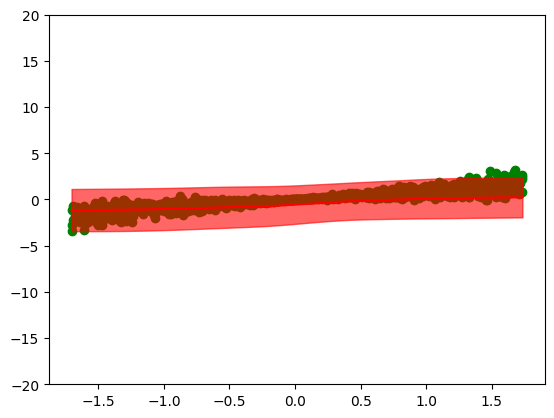

epoch=821/1000 | lr=(0.00001 (mu), 0.00001 (rho)) | loss=3780.38 = 3748.38 (nll) + 1.00 * 32.00 (kll) | ||mu|| = 6.32 | ||rho|| = 4.33
epoch=822/1000 | lr=(0.00001 (mu), 0.00001 (rho)) | loss=2113.60 = 2065.66 (nll) + 1.00 * 47.96 (kll) | ||mu|| = 6.32 | ||rho|| = 4.33
epoch=823/1000 | lr=(0.00001 (mu), 0.00001 (rho)) | loss=2477.96 = 2434.83 (nll) + 1.00 * 43.14 (kll) | ||mu|| = 6.32 | ||rho|| = 4.33
epoch=824/1000 | lr=(0.00001 (mu), 0.00001 (rho)) | loss=987.79 = 948.59 (nll) + 1.00 * 39.20 (kll) | ||mu|| = 6.32 | ||rho|| = 4.33
epoch=825/1000 | lr=(0.00001 (mu), 0.00001 (rho)) | loss=410.34 = 365.13 (nll) + 1.00 * 45.22 (kll) | ||mu|| = 6.32 | ||rho|| = 4.33
epoch=826/1000 | lr=(0.00001 (mu), 0.00001 (rho)) | loss=306.78 = 259.97 (nll) + 1.00 * 46.82 (kll) | ||mu|| = 6.32 | ||rho|| = 4.33
epoch=827/1000 | lr=(0.00001 (mu), 0.00001 (rho)) | loss=535.60 = 479.59 (nll) + 1.00 * 56.02 (kll) | ||mu|| = 6.32 | ||rho|| = 4.33
epoch=828/1000 | lr=(0.00001 (mu), 0.00001 (rho)) | loss=492.23

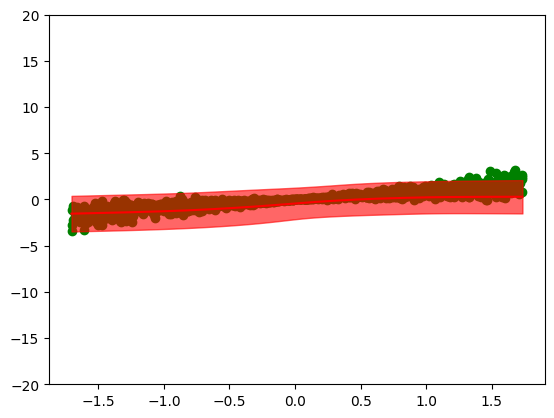

epoch=841/1000 | lr=(0.00001 (mu), 0.00001 (rho)) | loss=612.30 = 572.78 (nll) + 1.00 * 39.53 (kll) | ||mu|| = 6.32 | ||rho|| = 4.33
epoch=842/1000 | lr=(0.00001 (mu), 0.00001 (rho)) | loss=1678.11 = 1642.58 (nll) + 1.00 * 35.54 (kll) | ||mu|| = 6.32 | ||rho|| = 4.33
epoch=843/1000 | lr=(0.00001 (mu), 0.00001 (rho)) | loss=11010.22 = 10970.85 (nll) + 1.00 * 39.38 (kll) | ||mu|| = 6.32 | ||rho|| = 4.33
epoch=844/1000 | lr=(0.00001 (mu), 0.00001 (rho)) | loss=1943.70 = 1906.04 (nll) + 1.00 * 37.66 (kll) | ||mu|| = 6.32 | ||rho|| = 4.33
epoch=845/1000 | lr=(0.00001 (mu), 0.00001 (rho)) | loss=4050.52 = 4007.72 (nll) + 1.00 * 42.81 (kll) | ||mu|| = 6.32 | ||rho|| = 4.33
epoch=846/1000 | lr=(0.00001 (mu), 0.00001 (rho)) | loss=2022.55 = 1965.92 (nll) + 1.00 * 56.65 (kll) | ||mu|| = 6.32 | ||rho|| = 4.33
epoch=847/1000 | lr=(0.00001 (mu), 0.00001 (rho)) | loss=14587.17 = 14523.55 (nll) + 1.00 * 63.63 (kll) | ||mu|| = 6.32 | ||rho|| = 4.33
epoch=848/1000 | lr=(0.00001 (mu), 0.00001 (rho)) | l

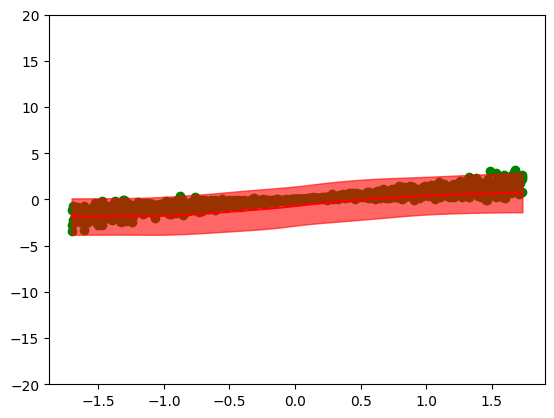

epoch=861/1000 | lr=(0.00001 (mu), 0.00001 (rho)) | loss=2410.28 = 2356.04 (nll) + 1.00 * 54.25 (kll) | ||mu|| = 6.32 | ||rho|| = 4.33
epoch=862/1000 | lr=(0.00001 (mu), 0.00001 (rho)) | loss=374.89 = 336.80 (nll) + 1.00 * 38.09 (kll) | ||mu|| = 6.32 | ||rho|| = 4.33
epoch=863/1000 | lr=(0.00001 (mu), 0.00001 (rho)) | loss=1062.98 = 998.93 (nll) + 1.00 * 64.06 (kll) | ||mu|| = 6.32 | ||rho|| = 4.33
epoch=864/1000 | lr=(0.00001 (mu), 0.00001 (rho)) | loss=575.21 = 539.68 (nll) + 1.00 * 35.54 (kll) | ||mu|| = 6.32 | ||rho|| = 4.33
epoch=865/1000 | lr=(0.00001 (mu), 0.00001 (rho)) | loss=1451.05 = 1400.61 (nll) + 1.00 * 50.45 (kll) | ||mu|| = 6.32 | ||rho|| = 4.33
epoch=866/1000 | lr=(0.00001 (mu), 0.00001 (rho)) | loss=8933.97 = 8886.40 (nll) + 1.00 * 47.58 (kll) | ||mu|| = 6.32 | ||rho|| = 4.33
epoch=867/1000 | lr=(0.00001 (mu), 0.00001 (rho)) | loss=4109.05 = 4054.77 (nll) + 1.00 * 54.28 (kll) | ||mu|| = 6.32 | ||rho|| = 4.33
epoch=868/1000 | lr=(0.00001 (mu), 0.00001 (rho)) | loss=619

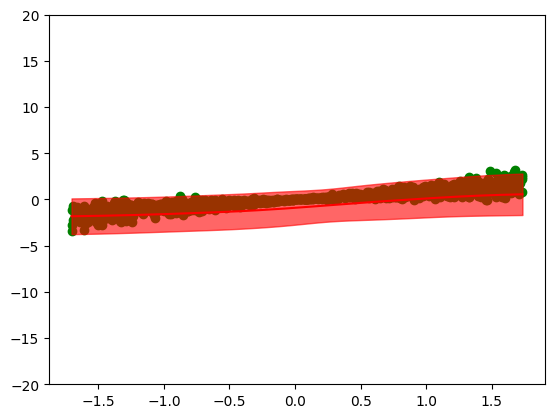

epoch=881/1000 | lr=(0.00001 (mu), 0.00001 (rho)) | loss=637.78 = 580.41 (nll) + 1.00 * 57.38 (kll) | ||mu|| = 6.32 | ||rho|| = 4.33
epoch=882/1000 | lr=(0.00001 (mu), 0.00001 (rho)) | loss=591.62 = 551.42 (nll) + 1.00 * 40.21 (kll) | ||mu|| = 6.32 | ||rho|| = 4.33
epoch=883/1000 | lr=(0.00001 (mu), 0.00001 (rho)) | loss=318.86 = 280.93 (nll) + 1.00 * 37.94 (kll) | ||mu|| = 6.32 | ||rho|| = 4.33
epoch=884/1000 | lr=(0.00001 (mu), 0.00001 (rho)) | loss=15364.84 = 15318.68 (nll) + 1.00 * 46.17 (kll) | ||mu|| = 6.32 | ||rho|| = 4.33
epoch=885/1000 | lr=(0.00001 (mu), 0.00001 (rho)) | loss=2375.41 = 2335.99 (nll) + 1.00 * 39.42 (kll) | ||mu|| = 6.32 | ||rho|| = 4.33
epoch=886/1000 | lr=(0.00001 (mu), 0.00001 (rho)) | loss=3191.89 = 3165.16 (nll) + 1.00 * 26.73 (kll) | ||mu|| = 6.32 | ||rho|| = 4.33
epoch=887/1000 | lr=(0.00001 (mu), 0.00001 (rho)) | loss=1054.86 = 1004.46 (nll) + 1.00 * 50.40 (kll) | ||mu|| = 6.32 | ||rho|| = 4.33
epoch=888/1000 | lr=(0.00001 (mu), 0.00001 (rho)) | loss=27

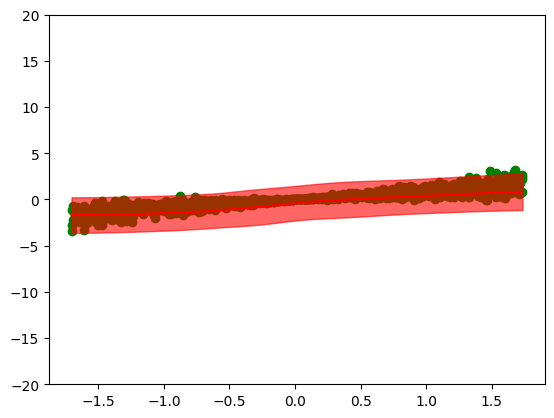

epoch=901/1000 | lr=(0.00001 (mu), 0.00001 (rho)) | loss=1922.71 = 1875.49 (nll) + 1.00 * 47.23 (kll) | ||mu|| = 6.32 | ||rho|| = 4.33
epoch=902/1000 | lr=(0.00001 (mu), 0.00001 (rho)) | loss=2893.75 = 2857.53 (nll) + 1.00 * 36.23 (kll) | ||mu|| = 6.32 | ||rho|| = 4.33
epoch=903/1000 | lr=(0.00001 (mu), 0.00001 (rho)) | loss=3375.06 = 3331.45 (nll) + 1.00 * 43.62 (kll) | ||mu|| = 6.32 | ||rho|| = 4.33
epoch=904/1000 | lr=(0.00001 (mu), 0.00001 (rho)) | loss=3655.86 = 3608.33 (nll) + 1.00 * 47.54 (kll) | ||mu|| = 6.32 | ||rho|| = 4.33
epoch=905/1000 | lr=(0.00001 (mu), 0.00001 (rho)) | loss=638.37 = 577.42 (nll) + 1.00 * 60.96 (kll) | ||mu|| = 6.32 | ||rho|| = 4.33
epoch=906/1000 | lr=(0.00001 (mu), 0.00001 (rho)) | loss=736.82 = 676.27 (nll) + 1.00 * 60.56 (kll) | ||mu|| = 6.32 | ||rho|| = 4.33
epoch=907/1000 | lr=(0.00001 (mu), 0.00001 (rho)) | loss=1095.80 = 1040.62 (nll) + 1.00 * 55.19 (kll) | ||mu|| = 6.32 | ||rho|| = 4.33
epoch=908/1000 | lr=(0.00001 (mu), 0.00001 (rho)) | loss=12

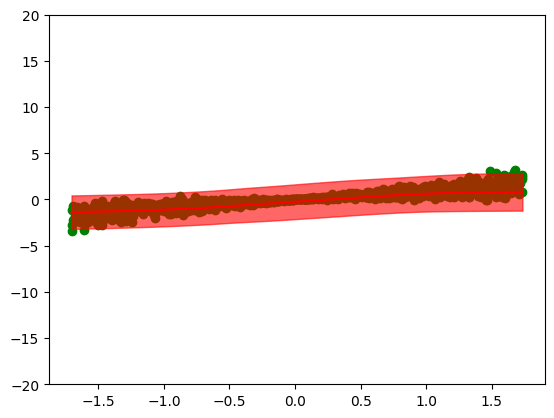

epoch=921/1000 | lr=(0.00001 (mu), 0.00001 (rho)) | loss=949.66 = 905.31 (nll) + 1.00 * 44.36 (kll) | ||mu|| = 6.32 | ||rho|| = 4.33
epoch=922/1000 | lr=(0.00001 (mu), 0.00001 (rho)) | loss=2393.58 = 2338.75 (nll) + 1.00 * 54.84 (kll) | ||mu|| = 6.32 | ||rho|| = 4.33
epoch=923/1000 | lr=(0.00001 (mu), 0.00001 (rho)) | loss=6069.14 = 6022.26 (nll) + 1.00 * 46.89 (kll) | ||mu|| = 6.32 | ||rho|| = 4.33
epoch=924/1000 | lr=(0.00001 (mu), 0.00001 (rho)) | loss=2093.60 = 2058.23 (nll) + 1.00 * 35.37 (kll) | ||mu|| = 6.32 | ||rho|| = 4.33
epoch=925/1000 | lr=(0.00001 (mu), 0.00001 (rho)) | loss=4115.06 = 4083.79 (nll) + 1.00 * 31.28 (kll) | ||mu|| = 6.32 | ||rho|| = 4.33
epoch=926/1000 | lr=(0.00001 (mu), 0.00001 (rho)) | loss=2532.60 = 2497.87 (nll) + 1.00 * 34.74 (kll) | ||mu|| = 6.32 | ||rho|| = 4.33
epoch=927/1000 | lr=(0.00001 (mu), 0.00001 (rho)) | loss=1157.50 = 1124.32 (nll) + 1.00 * 33.18 (kll) | ||mu|| = 6.32 | ||rho|| = 4.33
epoch=928/1000 | lr=(0.00001 (mu), 0.00001 (rho)) | loss=

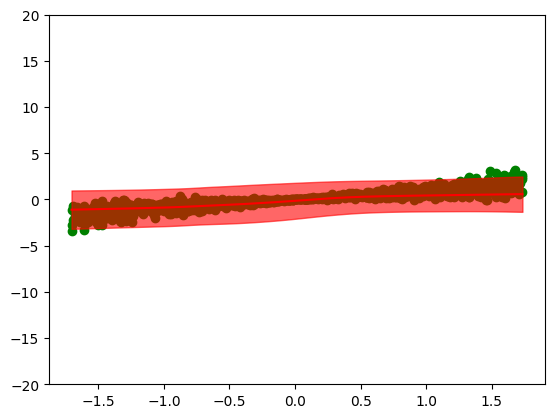

epoch=941/1000 | lr=(0.00001 (mu), 0.00001 (rho)) | loss=176.14 = 130.66 (nll) + 1.00 * 45.48 (kll) | ||mu|| = 6.32 | ||rho|| = 4.33
epoch=942/1000 | lr=(0.00001 (mu), 0.00001 (rho)) | loss=3167.97 = 3125.09 (nll) + 1.00 * 42.88 (kll) | ||mu|| = 6.32 | ||rho|| = 4.33
epoch=943/1000 | lr=(0.00001 (mu), 0.00001 (rho)) | loss=2137.22 = 2088.02 (nll) + 1.00 * 49.21 (kll) | ||mu|| = 6.32 | ||rho|| = 4.33
epoch=944/1000 | lr=(0.00001 (mu), 0.00001 (rho)) | loss=1229.63 = 1176.02 (nll) + 1.00 * 53.61 (kll) | ||mu|| = 6.32 | ||rho|| = 4.33
epoch=945/1000 | lr=(0.00001 (mu), 0.00001 (rho)) | loss=1371.92 = 1315.20 (nll) + 1.00 * 56.72 (kll) | ||mu|| = 6.32 | ||rho|| = 4.33
epoch=946/1000 | lr=(0.00001 (mu), 0.00001 (rho)) | loss=2339.68 = 2297.36 (nll) + 1.00 * 42.32 (kll) | ||mu|| = 6.32 | ||rho|| = 4.33
epoch=947/1000 | lr=(0.00001 (mu), 0.00001 (rho)) | loss=2688.01 = 2639.53 (nll) + 1.00 * 48.48 (kll) | ||mu|| = 6.32 | ||rho|| = 4.33
epoch=948/1000 | lr=(0.00001 (mu), 0.00001 (rho)) | loss=

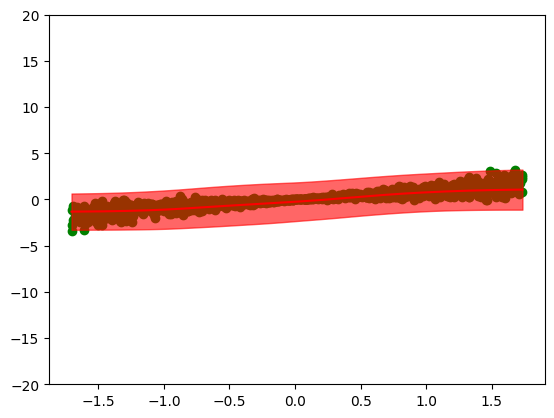

epoch=961/1000 | lr=(0.00001 (mu), 0.00001 (rho)) | loss=9075.48 = 9011.78 (nll) + 1.00 * 63.70 (kll) | ||mu|| = 6.32 | ||rho|| = 4.33
epoch=962/1000 | lr=(0.00001 (mu), 0.00001 (rho)) | loss=588.45 = 554.83 (nll) + 1.00 * 33.62 (kll) | ||mu|| = 6.32 | ||rho|| = 4.33
epoch=963/1000 | lr=(0.00001 (mu), 0.00001 (rho)) | loss=677.64 = 648.63 (nll) + 1.00 * 29.01 (kll) | ||mu|| = 6.32 | ||rho|| = 4.33
epoch=964/1000 | lr=(0.00001 (mu), 0.00001 (rho)) | loss=1159.82 = 1107.09 (nll) + 1.00 * 52.73 (kll) | ||mu|| = 6.32 | ||rho|| = 4.33
epoch=965/1000 | lr=(0.00001 (mu), 0.00001 (rho)) | loss=1723.31 = 1696.08 (nll) + 1.00 * 27.23 (kll) | ||mu|| = 6.32 | ||rho|| = 4.33
epoch=966/1000 | lr=(0.00001 (mu), 0.00001 (rho)) | loss=2148.80 = 2108.07 (nll) + 1.00 * 40.73 (kll) | ||mu|| = 6.32 | ||rho|| = 4.33
epoch=967/1000 | lr=(0.00001 (mu), 0.00001 (rho)) | loss=1134.53 = 1095.59 (nll) + 1.00 * 38.93 (kll) | ||mu|| = 6.32 | ||rho|| = 4.33
epoch=968/1000 | lr=(0.00001 (mu), 0.00001 (rho)) | loss=71

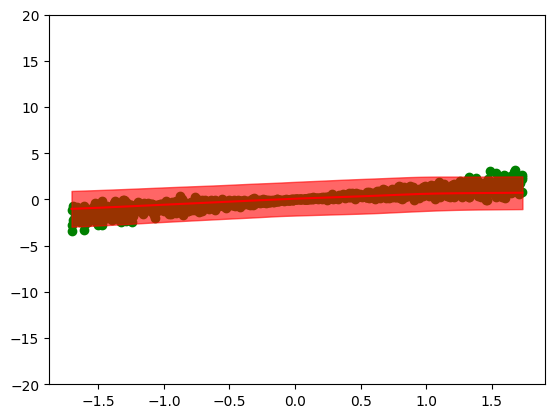

epoch=981/1000 | lr=(0.00001 (mu), 0.00001 (rho)) | loss=2236.61 = 2194.04 (nll) + 1.00 * 42.57 (kll) | ||mu|| = 6.32 | ||rho|| = 4.33
epoch=982/1000 | lr=(0.00001 (mu), 0.00001 (rho)) | loss=805.50 = 765.18 (nll) + 1.00 * 40.33 (kll) | ||mu|| = 6.32 | ||rho|| = 4.33
epoch=983/1000 | lr=(0.00001 (mu), 0.00001 (rho)) | loss=1851.40 = 1797.23 (nll) + 1.00 * 54.18 (kll) | ||mu|| = 6.32 | ||rho|| = 4.33
epoch=984/1000 | lr=(0.00001 (mu), 0.00001 (rho)) | loss=869.21 = 813.57 (nll) + 1.00 * 55.65 (kll) | ||mu|| = 6.32 | ||rho|| = 4.33
epoch=985/1000 | lr=(0.00001 (mu), 0.00001 (rho)) | loss=354.55 = 299.31 (nll) + 1.00 * 55.24 (kll) | ||mu|| = 6.32 | ||rho|| = 4.33
epoch=986/1000 | lr=(0.00001 (mu), 0.00001 (rho)) | loss=19795.73 = 19763.09 (nll) + 1.00 * 32.64 (kll) | ||mu|| = 6.32 | ||rho|| = 4.33
epoch=987/1000 | lr=(0.00001 (mu), 0.00001 (rho)) | loss=701.29 = 645.36 (nll) + 1.00 * 55.94 (kll) | ||mu|| = 6.32 | ||rho|| = 4.33
epoch=988/1000 | lr=(0.00001 (mu), 0.00001 (rho)) | loss=1387

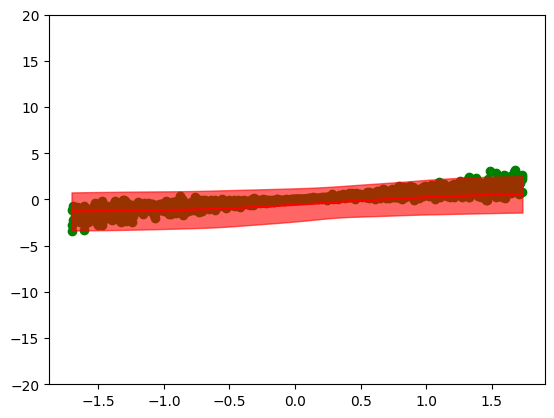

CPU times: total: 24.1 s
Wall time: 24.2 s


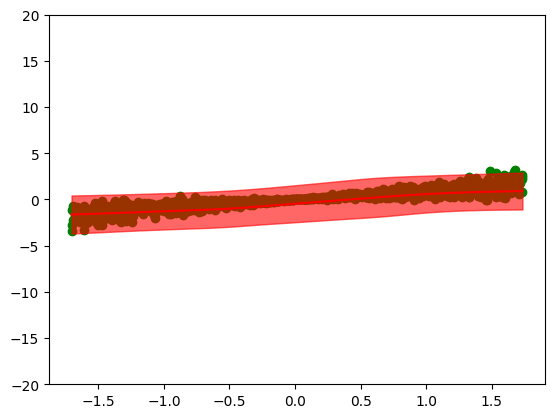

In [15]:
%%time
print(best_config)
model = BayesNetwork(num_input_features, num_output_features, device=device, **best_config)
train_with_lr_reducer(model, batch_size=1000, lr_mu_start=lr_mu_start, lr_rho_start=lr_rho_start, epochs=1000)

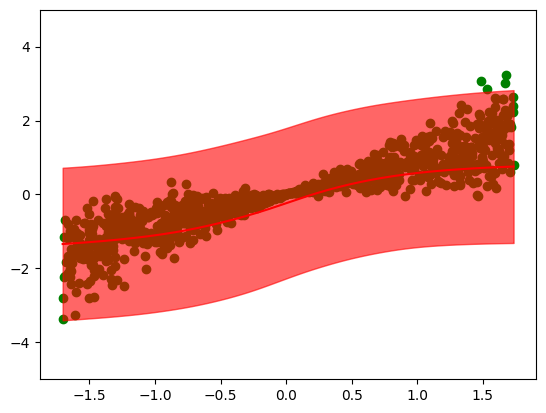

In [16]:
plot_credibility_interval(model, X_torch, y_torch, y_min=-5, y_max=5, num_samples=1000);

In [17]:
pd.Series(model.mu.detach().to(device="cpu").numpy()).describe()

count    97.000000
mean     -0.010938
std       0.644660
min      -1.324931
25%      -0.474484
50%      -0.008396
75%       0.412201
max       2.089688
dtype: float64

In [18]:
pd.Series(model.rho.detach().to(device="cpu").numpy()).describe()

count    97.000000
mean     -0.129944
std       0.421958
min      -1.858687
25%      -0.168235
50%      -0.036505
75%       0.049594
max       1.107322
dtype: float64

In [45]:
preds = []
for i in range(100):
    preds.append(model(torch.tensor([[-2]]))[0].item())
pd.DataFrame(preds).describe()

,0
count,100.000000
mean,-1.175838
std,0.075972
min,-1.304698
25%,-1.198262
50%,-1.177496
75%,-1.159680
max,-0.821330


In [46]:
predictions = []
# Run multiple forward passes to get predictions for each input
for _ in range(10):
    y_hat_sample = model(X_torch)[0]
    y_hat_np = y_hat_sample.to(device="cpu").detach().numpy().squeeze()
    predictions.append(y_hat_np)

# Convert the predictions to a NumPy array for easier manipulation
predictions = np.array(predictions)
predictions.shape


(10, 1000)